# **VAR** - *AAPL*
## Data Preparation

In [5]:
ticker =  "AAPL"

In [6]:
# 1) Import and reload your utils module
import importlib
import utils
importlib.reload(utils)

# 2) Bring the explode_sentiment_data function into scope
from utils import explode_sentiment_data

# explode_sentiment_data should have a signature like:
#   explode_sentiment_data(
#       ticker: str,
#       folder: str = 'news',
#       sentiment_lower: float = 0.3,
#       sentiment_upper: float = 0.3,
#       min_relevance_score: float = 0.5
#   ) -> (pd.DataFrame, pd.DataFrame)

# 1) Cargar noticias
df_news_full, df_news_filtered = explode_sentiment_data(
    ticker,
    folder="news",
    sentiment_lower=-0.2,
    sentiment_upper=0.2,
    min_relevance_score=0.5
)

# 2) Añadir índice una sola vez al full
df_news_full = df_news_full.reset_index(drop=True)
df_news_full["idx"] = df_news_full.index + 1  # LLM espera idx desde 1

# 3) Aplicar el índice también al filtrado, pero desde el full
df_news_filtered = df_news_full[df_news_full.index.isin(df_news_filtered.index)].copy()

# 4) Verificar
print("News Full:", df_news_full.shape)
print("News Filtered:", df_news_filtered.shape)

# 5) Ver algunos ejemplos
display(df_news_full.head(2))
display(df_news_filtered.head(2))


News Full: (27075, 8)
News Filtered: (3561, 8)


,time_published,day_date,week_date,title,summary,ticker_sentiment_score,ticker_relevance_score,idx
0,2022-03-04 21:27:00,2022-03-04,2022-02-28,Investor Lesson: Holding Great Companies Throu...,"If you want to do well as an investor, you hav...",0.030323,0.054535,1
1,2022-03-04 16:11:00,2022-03-04,2022-02-28,Broadcom ( AVGO ) Q1 Earnings and Revenues S...,Broadcom's (AVGO) first-quarter fiscal 2022 re...,-0.002192,0.100729,2


,time_published,day_date,week_date,title,summary,ticker_sentiment_score,ticker_relevance_score,idx
124,2022-03-09 17:59:43,2022-03-09,2022-03-07,Apple Launches New 5G iPhone SE,"Apple ( NASDAQ: AAPL ) , introduced several n...",0.608306,0.515127,125
208,2022-03-08 12:53:15,2022-03-08,2022-03-07,South Korea Passes App Store Law Challenging A...,South Korea approved detailed rules for a law ...,-0.281480,0.629492,209


In [7]:
import importlib
import utils
from utils import load_prices

df_prices_daily = load_prices(ticker, frequency='daily', folder='stocks')

df_prices_daily = df_prices_daily.reset_index()

df_prices_daily.columns = [
    "day_date",         # previously 'date'
    "open",             # "1. open"
    "high",             # "2. high"
    "low",              # "3. low"
    "close",            # "4. close"
    "adjusted_close",   # already renamed
    "volume",           # "6. volume"
    "dividend_amount",  # "7. dividend amount"
    "split_coefficient" # "8. split coefficient"
]
df_prices_daily.head()


,day_date,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,1999-11-01,80.00,80.69,77.37,77.62,0.583913,2487300,0.0,1.0
1,1999-11-02,78.00,81.69,77.31,80.25,0.603697,3564600,0.0,1.0
2,1999-11-03,81.62,83.25,81.00,81.50,0.613101,2932700,0.0,1.0
3,1999-11-04,82.06,85.37,80.62,83.62,0.629049,3384700,0.0,1.0
4,1999-11-05,84.62,88.37,84.00,88.31,0.664331,3721500,0.0,1.0


In [8]:
import pandas as pd

df_news_filtered["day_date"] = pd.to_datetime(df_news_filtered["day_date"])

df_merged = pd.merge(df_news_filtered, df_prices_daily, on="day_date", how="left")

df_merged.columns

Index(['time_published', 'day_date', 'week_date', 'title', 'summary',
       'ticker_sentiment_score', 'ticker_relevance_score', 'idx', 'open',
       'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amount',
       'split_coefficient'],
      dtype='object')

# **VAR** AAPL - *Full*
### Data Preparation

In [9]:
import pandas as pd
from functools import reduce
from pathlib import Path


# 2) Build the base directory where your LLM files live
base_dir = Path(r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\llm") / ticker

# 3) Define file names
files = {
    "df_news_llm": f"df___{ticker}___llm.csv",
    "df_news_llm_tech": f"df___{ticker}___llm_tech.csv",
    "df_news_llm_tech_fund": f"df___{ticker}___llm_tech_fund.csv"
}

# 4) Load into variables
df_news_llm = pd.read_csv(base_dir / files["df_news_llm"])
df_news_llm_tech = pd.read_csv(base_dir / files["df_news_llm_tech"])
df_news_llm_tech_fund = pd.read_csv(base_dir / files["df_news_llm_tech_fund"])

df_news_av = df_news_filtered.copy()

df_news_av = df_news_av.rename(columns={
    "ticker_sentiment_score": "TSS_av",
    "ticker_relevance_score": "TRS_av"
})
df_news_av = df_news_av[["idx", "time_published","day_date","week_date","TSS_av", "TRS_av"]]

df_news_llm = df_news_llm.rename(columns={
    "ticker_sentiment_score": "TSS_llm",
    "ticker_relevance_score": "TRS_llm",
    "ticker_price_impact": "TPI_llm"
})
df_news_llm = df_news_llm[["idx", "TSS_llm", "TRS_llm", "TPI_llm"]]

df_news_llm_tech = df_news_llm_tech.rename(columns={
    "ticker_sentiment_score": "TSS_llm_t",
    "ticker_relevance_score": "TRS_llm_t",
    "ticker_price_impact": "TPI_llm_t"
})
df_news_llm_tech = df_news_llm_tech[["idx", "TSS_llm_t", "TRS_llm_t", "TPI_llm_t"]]

df_news_llm_tech_fund = df_news_llm_tech_fund.rename(columns={
    "ticker_sentiment_score": "TSS_llm_t_f",
    "ticker_relevance_score": "TRS_llm_t_f",
    "ticker_price_impact": "TPI_llm_t_f"
})
df_news_llm_tech_fund = df_news_llm_tech_fund[["idx", "TSS_llm_t_f", "TRS_llm_t_f", "TPI_llm_t_f"]]

# Lista de todos los DataFrames a unir
dfs = [
    df_news_av,
    df_news_llm,
    df_news_llm_tech,
    df_news_llm_tech_fund
]

# Usamos reduce + pd.merge para hacer un merge sucesivo por 'idx'
df_combined = reduce(
    lambda left, right: pd.merge(left, right, on='idx', how='inner'),
    dfs
)

df_combined.columns

Index(['idx', 'time_published', 'day_date', 'week_date', 'TSS_av', 'TRS_av',
       'TSS_llm', 'TRS_llm', 'TPI_llm', 'TSS_llm_t', 'TRS_llm_t', 'TPI_llm_t',
       'TSS_llm_t_f', 'TRS_llm_t_f', 'TPI_llm_t_f'],
      dtype='object')

In [10]:
import pandas as pd
import numpy as np
import importlib

# importa y recarga tu módulo de utilidades
import utils
importlib.reload(utils)
from utils import load_prices

# --- función de agregados ponderados y filtrados ---
def aggregate_all_sentiments(
    df: pd.DataFrame,
    drop_columns: list = ["valuation_label"]
) -> tuple[pd.DataFrame, pd.DataFrame]:
    # copia y limpio
    df_clean = df.drop(columns=drop_columns, errors='ignore').copy()
    df_clean['day_date']  = pd.to_datetime(df_clean['day_date'])
    df_clean['week_date'] = (
        df_clean['day_date']
        .dt.to_period('W')
        .apply(lambda r: r.start_time.date())
    )
    df_clean['week_date'] = pd.to_datetime(df_clean['week_date'])

    # filtro de relevancia (igual que antes)
    df_filt = df_clean[df_clean['TRS_llm'] > 0.6].copy()

    # ---- aquí añadimos TODOS los weighted de TSS_* usando su TRS correspondiente ----
    bases = ['llm', 'llm_t', 'llm_t_f', 'av']
    for b in bases:
        tss_col = f"TSS_{b}"
        trs_col = f"TRS_{b}"
        wcol    = f"{tss_col}_weighted"
        if tss_col in df_filt.columns and trs_col in df_filt.columns:
            df_filt[wcol] = df_filt[tss_col] * df_filt[trs_col]

    # selecciono todas las métricas resultantes (incluye ahora los nuevos _weighted)
    selected_cols = [
        c for c in df_filt.columns
        if c.startswith(('TSS_','TRS_','TPI_'))
    ]

    # agrego por día y por semana
    daily  = (
        df_filt
        .groupby('day_date')[selected_cols]
        .mean()
        .reset_index()
    )
    weekly = (
        df_filt
        .groupby('week_date')[selected_cols]
        .mean()
        .reset_index()
    )

    return daily, weekly

# --- ejecutamos sobre tu df_combined preexistente ---
daily_agg_comb, weekly_agg_comb = aggregate_all_sentiments(df_combined)

# precios diarios
df_prices_daily = load_prices(ticker, frequency='daily', folder='stocks') \
                    .reset_index() \
                    .rename(columns={'date':'day_date'})
df_prices_daily['day_date'] = pd.to_datetime(df_prices_daily['day_date'])

# precios semanales
df_prices_weekly = load_prices(ticker, frequency='weekly', folder='stocks') \
                    .reset_index() \
                    .rename(columns={'date':'week_date'})
df_prices_weekly['week_date'] = pd.to_datetime(df_prices_weekly['week_date'])

# --- merges por fecha ---
merged_daily  = pd.merge(daily_agg_comb,  df_prices_daily,  on='day_date',  how='inner')

# 1) Crea una columna "periodo_semana" en ambos dfs
weekly_agg_comb['periodo_semana']   = weekly_agg_comb['week_date'].dt.to_period('W')
df_prices_weekly['periodo_semana'] = df_prices_weekly['week_date'].dt.to_period('W')

# 2) Merge sobre el periodo
merged_weekly = pd.merge(
    weekly_agg_comb,
    df_prices_weekly,
    on='periodo_semana',
    how='inner'
)

# 3) (opcional) Si quieres volver a una fecha concreta,
#    puedes elegir el inicio ó el fin del periodo:
merged_weekly['week_start'] = merged_weekly['periodo_semana'].dt.start_time
merged_weekly['week_end']   = merged_weekly['periodo_semana'].dt.end_time

# --- creamos lags de retornos ---
for lag in (2, 3):
    merged_daily[f'return_d+{lag}']     = merged_daily['adjusted_close'].shift(-lag)/merged_daily['adjusted_close'] - 1
    merged_daily[f'log_return_d+{lag}'] = np.log(merged_daily['adjusted_close'].shift(-lag)) - np.log(merged_daily['adjusted_close'])

for lag in (2,):
    merged_weekly[f'return_w+{lag}']     = merged_weekly['adjusted_close'].shift(-lag)/merged_weekly['adjusted_close'] - 1
    merged_weekly[f'log_return_w+{lag}'] = np.log(merged_weekly['adjusted_close'].shift(-lag)) - np.log(merged_weekly['adjusted_close'])

# --- preview ---
print("✅ merged_daily:")
print(merged_daily.head(3))
print("\n✅ merged_weekly:")
print(merged_weekly.head(3))


✅ merged_daily:
    day_date    TSS_av    TRS_av  TSS_llm  TRS_llm  TPI_llm  TSS_llm_t  \
0 2022-03-07 -0.219456  0.526629   -0.225     0.75     -0.2     -0.075   
1 2022-03-08 -0.281480  0.629492   -0.800     0.85     -0.7      0.100   
2 2022-03-09  0.608306  0.515127    0.750     0.90      0.6      0.500   

   TRS_llm_t  TPI_llm_t  TSS_llm_t_f  ...  3. low  4. close  adjusted_close  \
0       0.70       -0.2          0.0  ...  159.04    159.30      156.764994   
1       0.90       -0.3         -0.4  ...  155.80    157.44      154.934593   
2       0.95        0.7          0.6  ...  159.41    162.95      160.356910   

   6. volume  7. dividend amount  8. split coefficient  return_d+2  \
0   96418845                 0.0                   1.0    0.022913   
1  131148280                 0.0                   1.0   -0.043318   
2   91454905                 0.0                   1.0   -0.020620   

   log_return_d+2  return_d+3  log_return_d+3  
0        0.022654   -0.054488       -0.05

In [11]:
# --- 1) Rename merged_daily price columns ---
merged_daily = merged_daily.rename(columns={
    "1. open":           "open",
    "2. high":           "high",
    "3. low":            "low",
    "4. close":          "close",
    "5. adjusted_close": "adjusted_close",  # if already that name you can drop
    "6. volume":         "volume",
    "7. dividend amount":"dividend"
})

# Ensure the weekly‐return column is also simply named
merged_daily = merged_daily.rename(columns={
    "return_d":    "return_d",
    "return_d+2":  "return_d+2",
    "return_d+3":  "return_d+3",
    "log_return_d+2": "log_return_d+2",
    "log_return_d+3": "log_return_d+3"
})

# If your merged_daily still has both day_date and some other date column, 
# make sure 'day_date' is the index or the canonical date field:
merged_daily['day_date'] = pd.to_datetime(merged_daily['day_date'])
merged_daily = merged_daily.set_index('day_date', drop=False)


# --- 2) Rename merged_weekly price columns & tidy up week_date ---
# First drop the duplicate week_date_y if it exists, then rename week_date_x → week_date
if 'week_date_y' in merged_weekly.columns:
    merged_weekly = merged_weekly.drop(columns=['week_date_y'])

merged_weekly = merged_weekly.rename(columns={
    'week_date_x':      'week_date',
    "1. open":          "open",
    "2. high":          "high",
    "3. low":           "low",
    "4. close":         "close",
    "5. adjusted_close":"adjusted_close",
    "6. volume":        "volume",
    "7. dividend amount":"dividend",
    # your returns lags:
    "return_w":         "return_w",
    "return_w+2":       "return_w+2",
    "log_return_w+2":   "log_return_w+2"
})

# convert week_date to datetime and set index if you like
merged_weekly['week_date'] = pd.to_datetime(merged_weekly['week_date'])
merged_weekly = merged_weekly.set_index('week_date', drop=False)


# --- 3) Verify ---
print(merged_daily.columns)
print(merged_weekly.columns)


Index(['day_date', 'TSS_av', 'TRS_av', 'TSS_llm', 'TRS_llm', 'TPI_llm',
       'TSS_llm_t', 'TRS_llm_t', 'TPI_llm_t', 'TSS_llm_t_f', 'TRS_llm_t_f',
       'TPI_llm_t_f', 'TSS_llm_weighted', 'TSS_llm_t_weighted',
       'TSS_llm_t_f_weighted', 'TSS_av_weighted', 'open', 'high', 'low',
       'close', 'adjusted_close', 'volume', 'dividend', '8. split coefficient',
       'return_d+2', 'log_return_d+2', 'return_d+3', 'log_return_d+3'],
      dtype='object')
Index(['week_date', 'TSS_av', 'TRS_av', 'TSS_llm', 'TRS_llm', 'TPI_llm',
       'TSS_llm_t', 'TRS_llm_t', 'TPI_llm_t', 'TSS_llm_t_f', 'TRS_llm_t_f',
       'TPI_llm_t_f', 'TSS_llm_weighted', 'TSS_llm_t_weighted',
       'TSS_llm_t_f_weighted', 'TSS_av_weighted', 'periodo_semana', 'open',
       'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend',
       'week_start', 'week_end', 'return_w+2', 'log_return_w+2'],
      dtype='object')


# ***AV & LLMs*** - Daily, +1, +2, +3

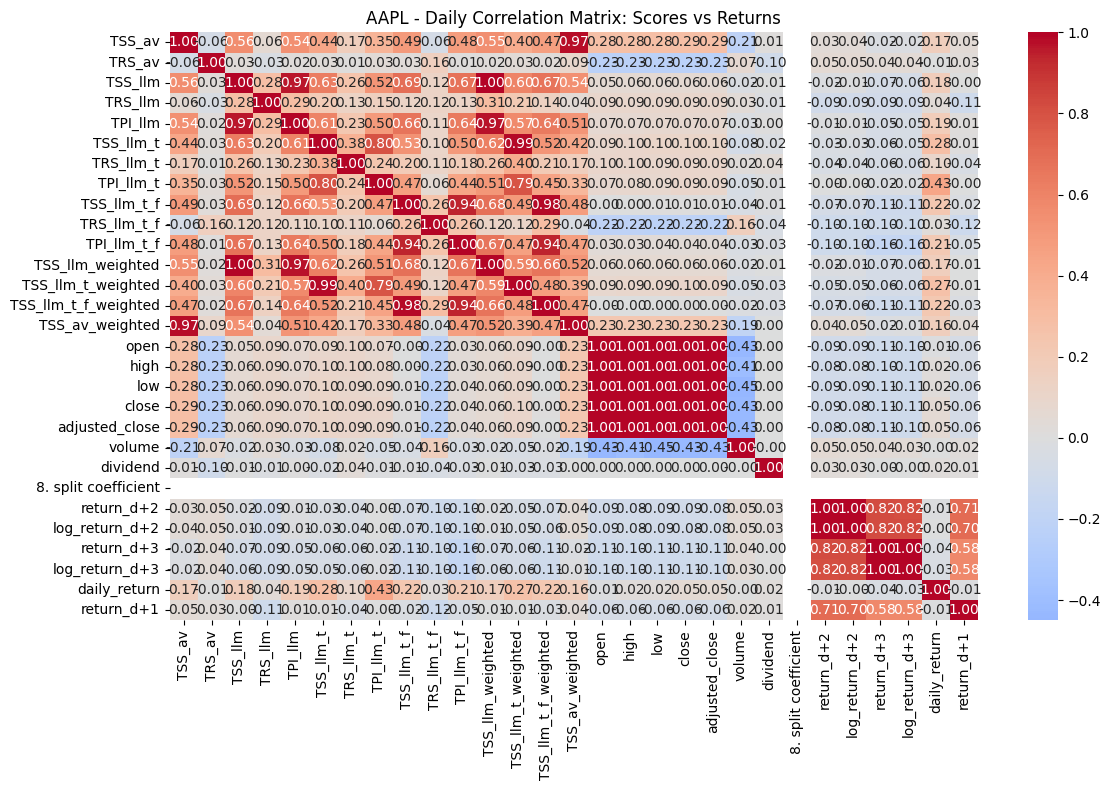

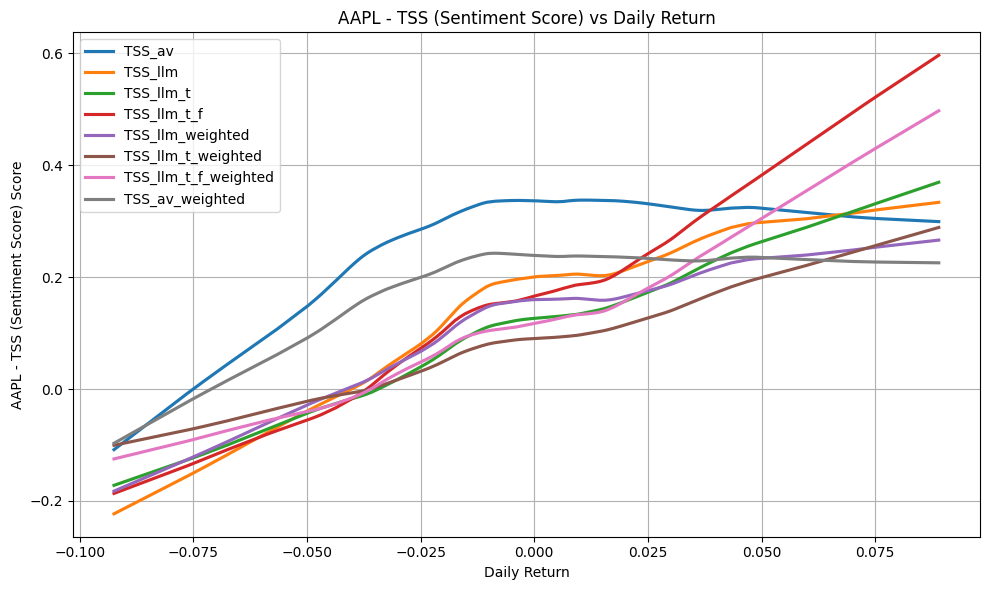

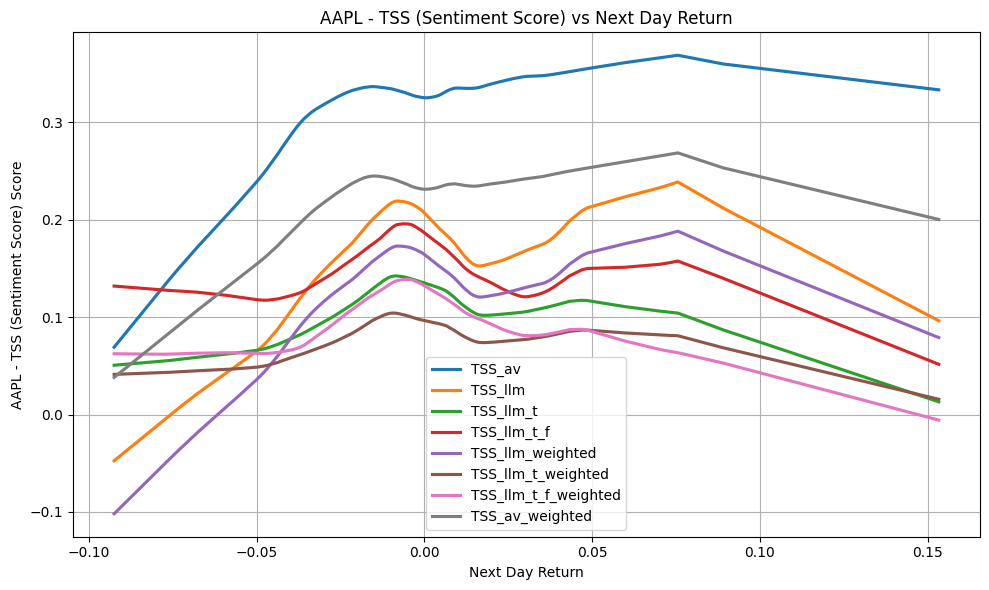

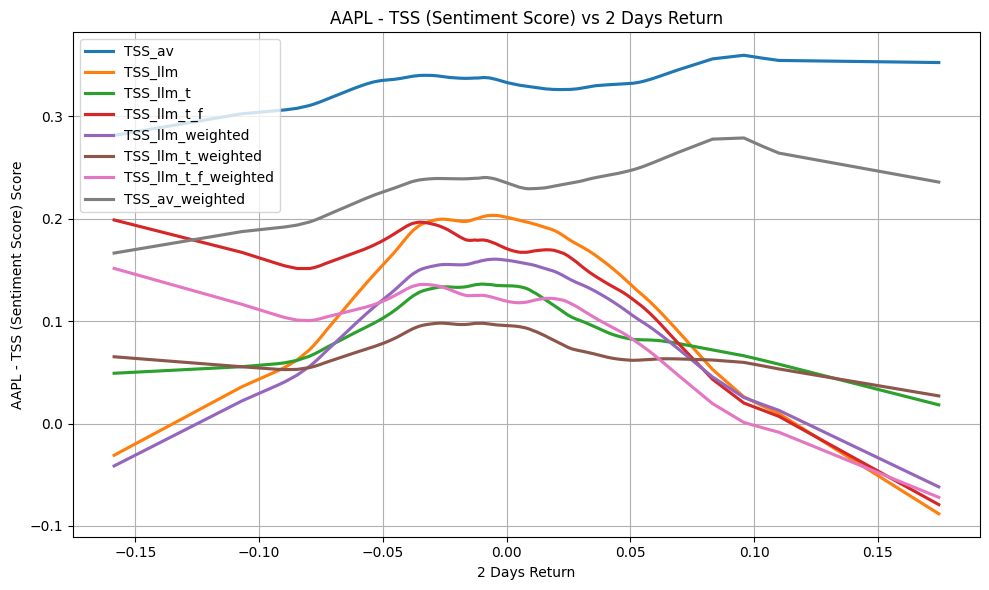

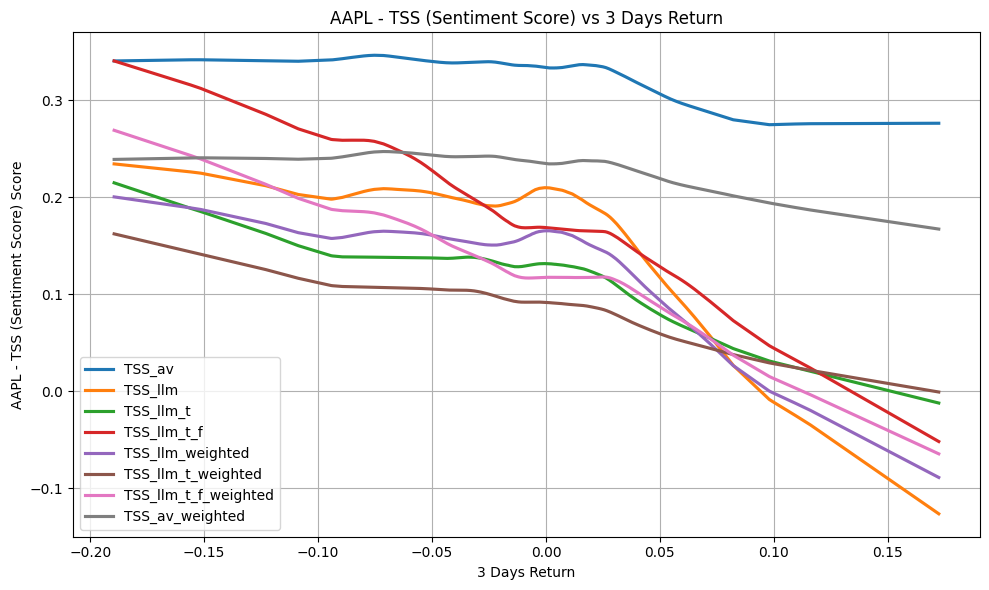

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ─── 1) Ensure merged_daily has a daily_return column ───────────────────────
# If you haven’t already, compute:
# merged_daily['daily_return'] = merged_daily['adjusted_close'].pct_change()
# and then drop NaNs in that column before plotting.

df = merged_daily.copy()
df['daily_return'] = df['adjusted_close'].pct_change()
df['return_d+1'] = df['adjusted_close'].shift(-1) / df['adjusted_close'] - 1
df = df.dropna(subset=['daily_return', 'return_d+1'])

# ─── 2) Correlation matrix ───────────────────────────────────────────────────
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title(f"{ticker} - Daily Correlation Matrix: Scores vs Returns")
plt.tight_layout()
plt.show()

# ─── 3) LOWESS‐smoothed regression plots ─────────────────────────────────────
x_vars = {
    "daily_return": "Daily Return",
    "return_d+1":   "Next Day Return",
    "return_d+2":   "2 Days Return",
    "return_d+3":   "3 Days Return"
}
# Group your sentiment / relevance / impact score columns
score_groups = {
    f"{ticker} - TSS (Sentiment Score)": [c for c in df.columns if c.startswith("TSS_")]
    # "TRS": [c for c in df.columns if c.startswith("TRS_")],
    # "TPI": [c for c in df.columns if c.startswith("TPI_")]
}

for score_type, cols in score_groups.items():
    for x_col, x_label in x_vars.items():
        if x_col not in df.columns:
            continue

        sub = df.dropna(subset=[x_col] + cols)
        if sub.empty:
            continue

        plt.figure(figsize=(10, 6))
        for score_col in cols:
            sns.regplot(
                data=sub,
                x=x_col,
                y=score_col,
                lowess=True,
                scatter=False,
                label=score_col
            )

        plt.xlabel(x_label)
        plt.ylabel(f"{score_type} Score")
        plt.title(f"{score_type} vs {x_label}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# ***AV & LLMs*** - Weekly, +1, +2, +3

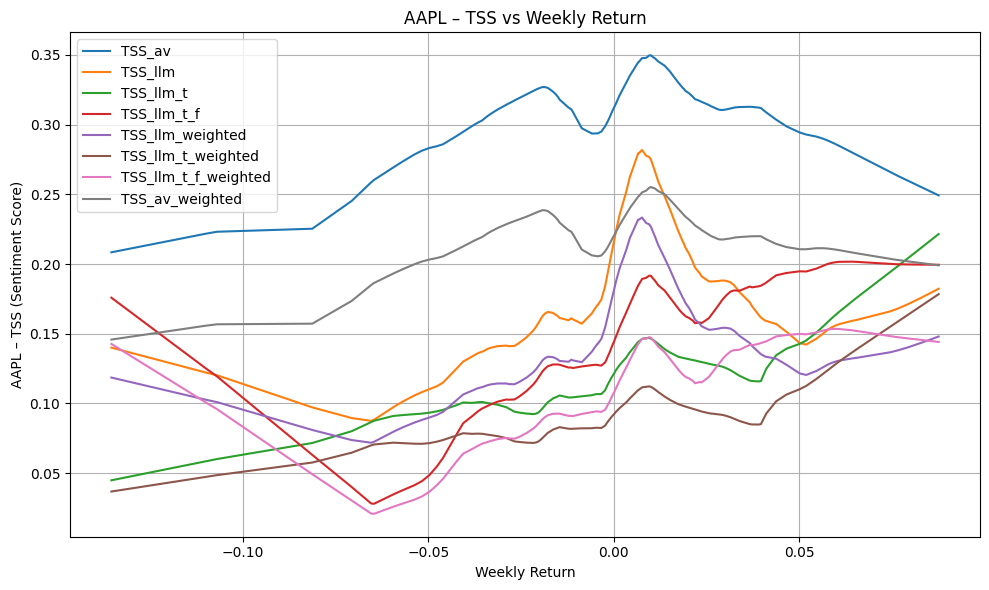

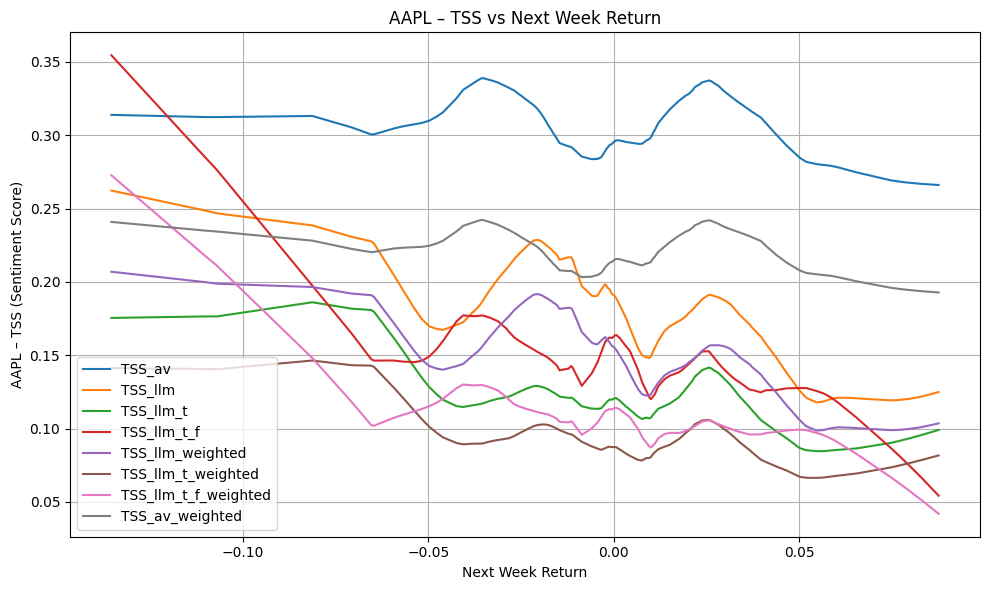

In [13]:
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

# --- 1) Compute weekly returns and 1-week-ahead return ---
merged_weekly['return_w']   = merged_weekly['adjusted_close'].pct_change()
merged_weekly['return_w+1'] = (
    merged_weekly['adjusted_close'].shift(-1)
    / merged_weekly['adjusted_close']
    - 1
)

# --- 2) Pick up all your TSS columns ---
tss_cols = [c for c in merged_weekly.columns if c.startswith('TSS_')]

# --- 3) Define the two X-axes you want to plot against ---
x_vars_w = {
    'return_w':   'Weekly Return',
    'return_w+1': 'Next Week Return'
}

# --- 4) Loop through each and LOWESS-plot ---
for x_col, x_label in x_vars_w.items():
    # drop any NaNs in the horizon or in any TSS
    dfw = merged_weekly.dropna(subset=[x_col] + tss_cols)
    if dfw.empty:
        continue

    plt.figure(figsize=(10,6))
    for score_col in tss_cols:
        sm = lowess(dfw[score_col], dfw[x_col], frac=0.3)
        plt.plot(sm[:,0], sm[:,1], label=score_col)

    plt.xlabel(x_label)
    plt.ylabel(f"{ticker} – TSS (Sentiment Score)")
    plt.title(f"{ticker} – TSS vs {x_label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ***AV & LLMs*** - Daily Return, Change in Price & Volume Change

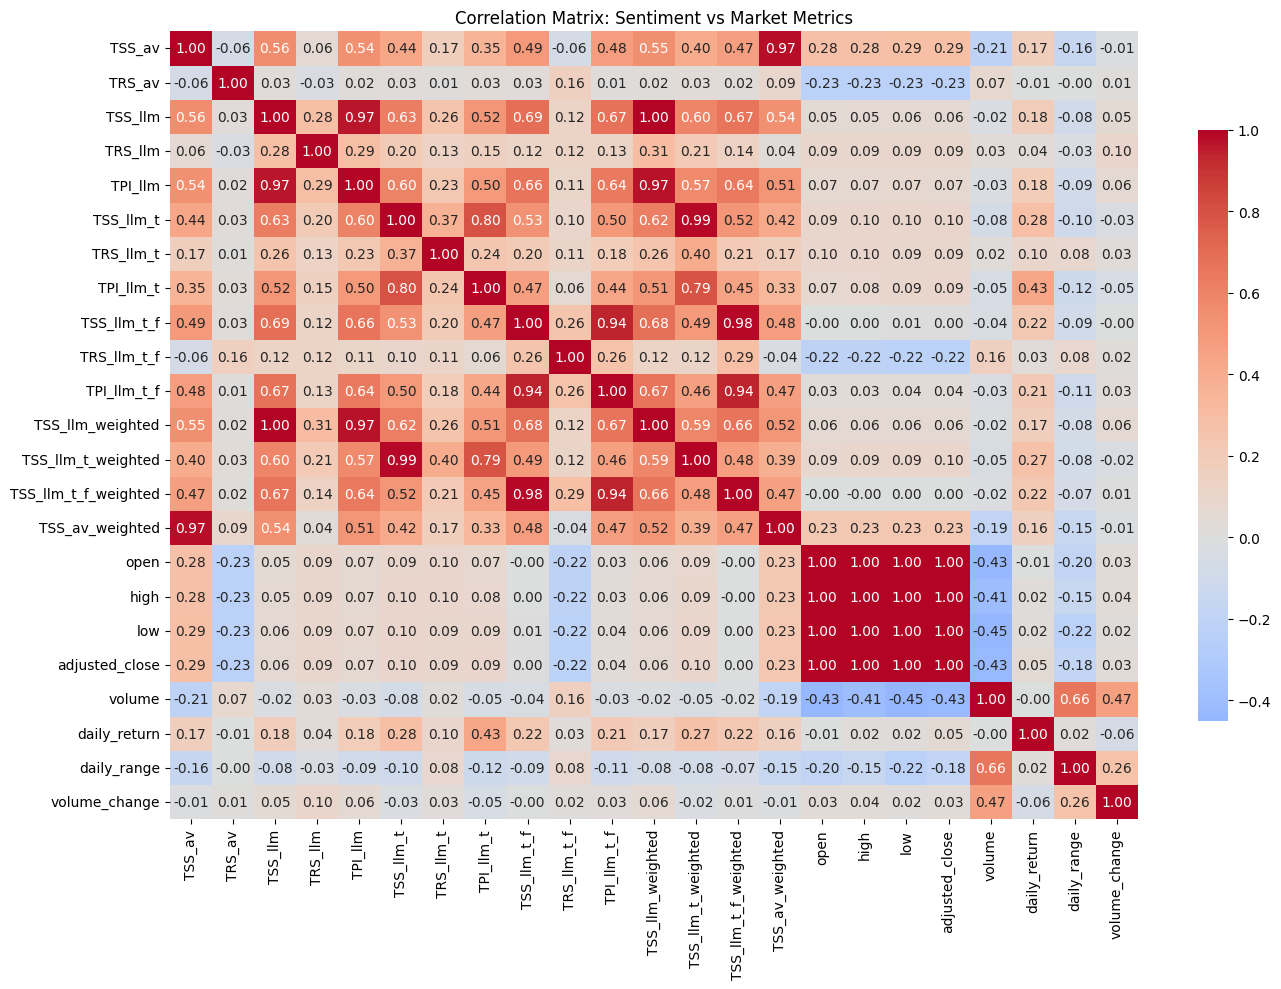

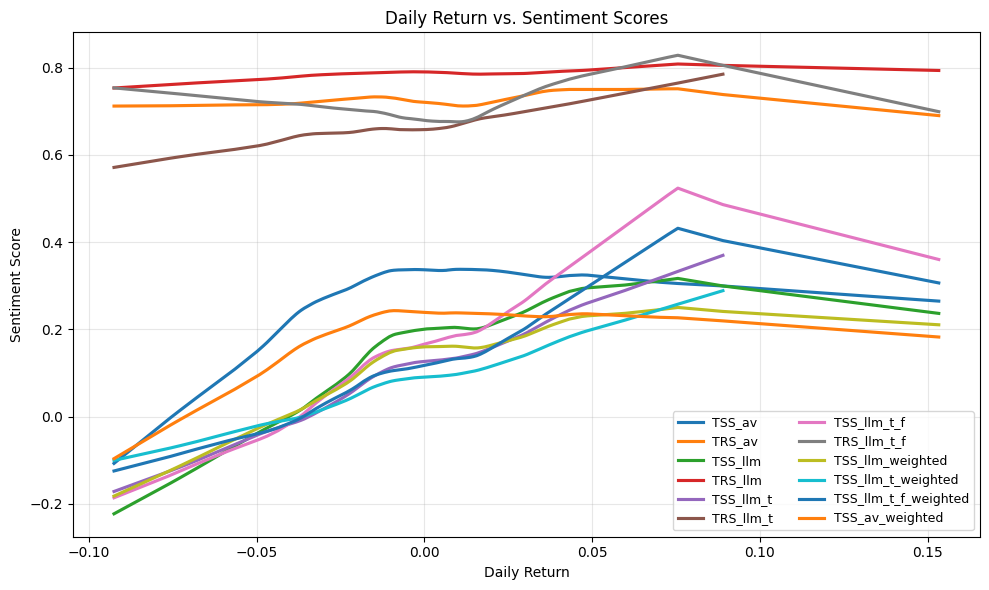

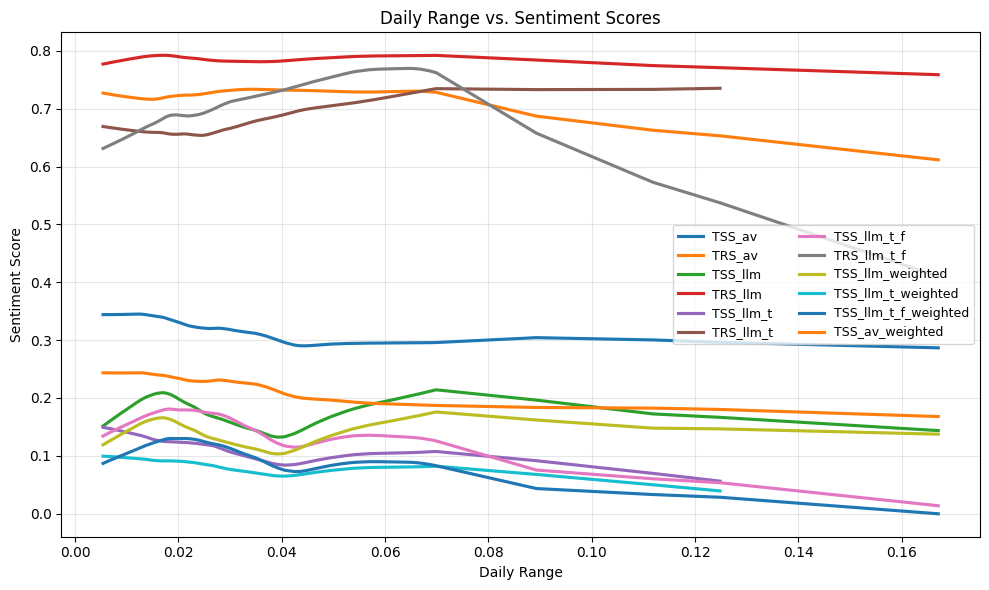

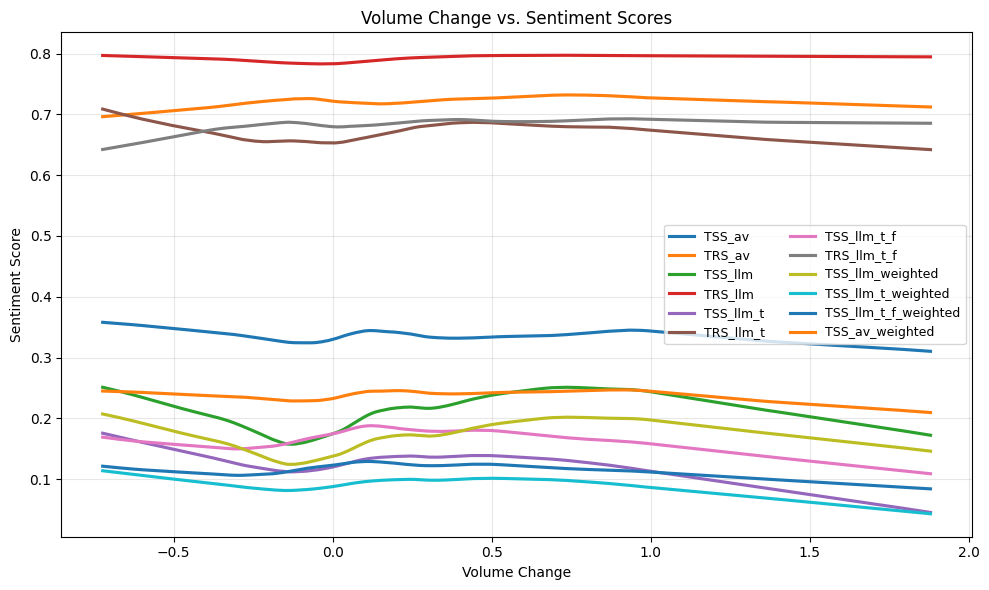

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_prices

# 1) Ensure your sentiment DataFrame has a datetime 'day_date'
daily_agg_comb['day_date'] = pd.to_datetime(daily_agg_comb['day_date'])

# 2) Load full daily price series for ticker
df_prices = (
    load_prices(ticker, frequency="daily", folder="stocks")
    .reset_index()
    .rename(columns={'date': 'day_date'})
)
df_prices['day_date'] = pd.to_datetime(df_prices['day_date'])

# 3) Merge sentiment + price
df = (
    daily_agg_comb
    .merge(
        df_prices[['day_date',
                   '1. open', '2. high', '3. low',
                   'adjusted_close', '6. volume']],
        on='day_date', how='inner'
    )
    .rename(columns={
        '1. open': 'open',
        '2. high': 'high',
        '3. low': 'low',
        'adjusted_close': 'adjusted_close',
        '6. volume': 'volume'
    })
    .sort_values('day_date')
    .reset_index(drop=True)
)

# 4) Compute daily_return from adjusted_close, plus other metrics
df['daily_return']  = df['adjusted_close'].pct_change()      # t → t+1 return
df['daily_range']   = (df['high'] - df['low']) / df['low']   # intraday swing
df['volume_change'] = df['volume'].pct_change()             # day-over-day volume change

# drop rows where any of these new metrics are NaN
df = df.dropna(subset=['daily_return','volume_change']).reset_index(drop=True)

# 5) Correlation heatmap among all numeric columns
plt.figure(figsize=(14,10))
sns.heatmap(
    df.select_dtypes(include='number').corr(),
    annot=True, fmt='.2f',
    cmap='coolwarm', center=0,
    cbar_kws={'shrink': .75}
)
plt.title("Correlation Matrix: Sentiment vs Market Metrics")
plt.tight_layout()
plt.show()

# 6) LOWESS scatter‐plots: each sentiment series vs each market variable
sentiment_cols = [c for c in df.columns if c.startswith(('TSS_','TRS_'))]
market_vars    = ['daily_return','daily_range','volume_change']

for mv in market_vars:
    plt.figure(figsize=(10,6))
    for sc in sentiment_cols:
        sns.regplot(
            x=mv, y=sc,
            data=df,
            lowess=True,
            scatter=False,
            label=sc
        )
    plt.xlabel(mv.replace('_',' ').title())
    plt.ylabel("Sentiment Score")
    plt.title(f"{mv.replace('_',' ').title()} vs. Sentiment Scores")
    plt.legend(ncol=2, fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


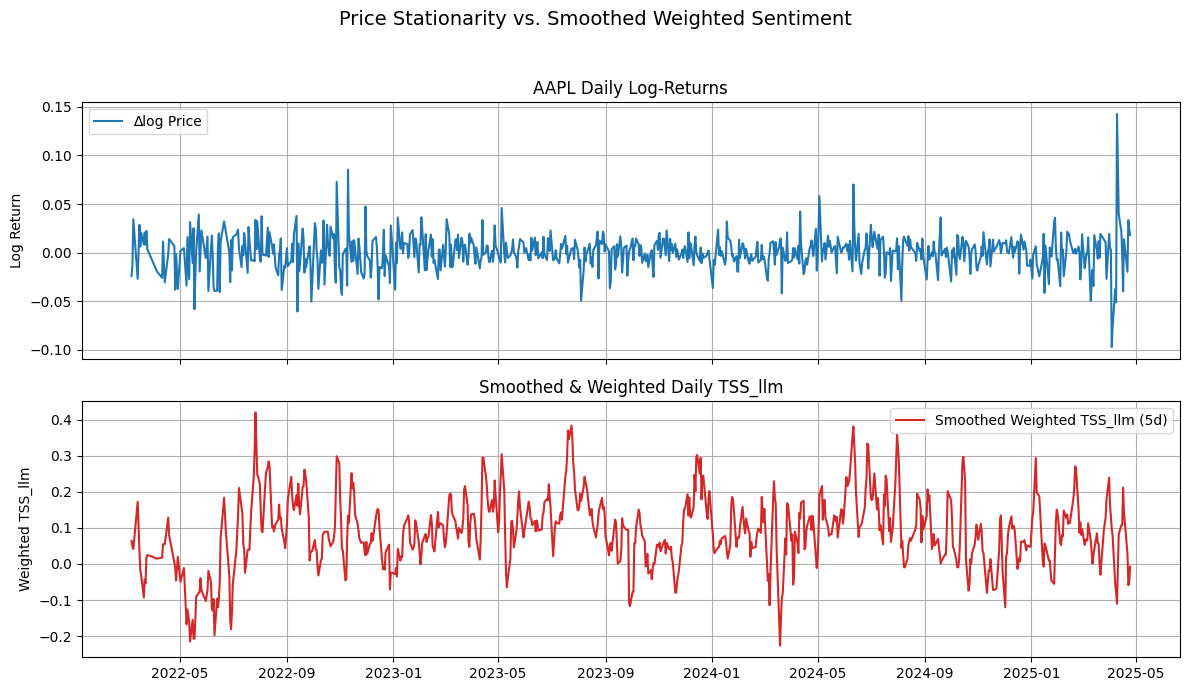

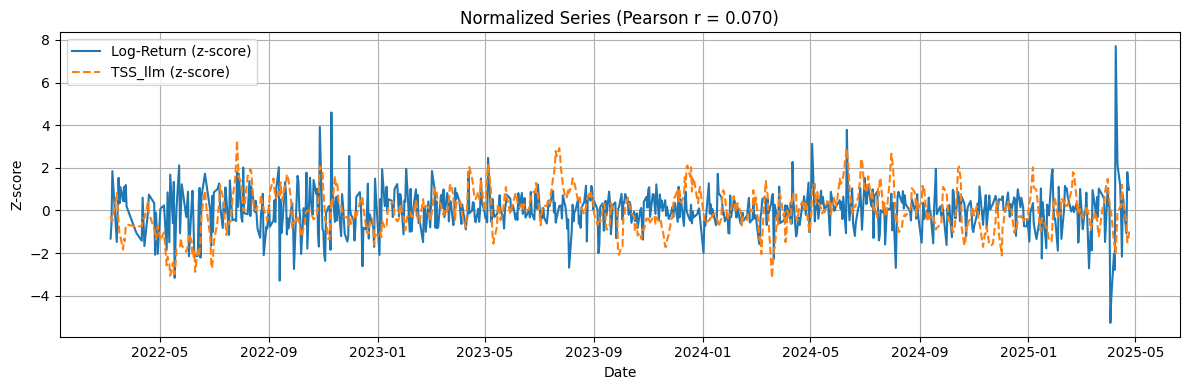

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import load_prices

# ── 1) Compute daily log‐returns for ticker ─────────────────────────────────────
price_df = load_prices(ticker, frequency='daily', folder='stocks').copy()
price_df.index.name = 'day_date'
price_df = price_df.sort_index()

# compute ∆log P = log(P_t / P_{t-1})
price_df['log_return'] = np.log(price_df['adjusted_close'] / price_df['adjusted_close'].shift(1))
price_df = price_df.dropna(subset=['log_return'])

# reset index into a column
price_returns = price_df[['log_return']].reset_index()

# ── 2) Build a **weighted, smoothed** daily-TSS_llm series ─────────────────────
#    (weight by relevance and smooth over a 5-day window)
# assume df_combined already loaded and has columns:
#     'day_date', 'TSS_llm', 'TRS_llm'
df_combined['day_date'] = pd.to_datetime(df_combined['day_date'])
df_combined['TSS_llm_weighted'] = df_combined['TSS_llm'] * df_combined['TRS_llm']

# daily average + 5-day rolling mean
tss_daily = (
    df_combined
      .groupby('day_date')['TSS_llm_weighted']
      .mean()
      .rolling(window=5, center=True, min_periods=1)
      .mean()
      .reset_index()
      .rename(columns={'TSS_llm_weighted':'smoothed_weighted_TSS_llm'})
)

# ── 3) Merge returns and sentiment on day_date ────────────────────────────────
merged = pd.merge(
    price_returns,
    tss_daily,
    on='day_date',
    how='inner'
).sort_values('day_date').reset_index(drop=True)

# ── 4) Plot time series ───────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

ax1.plot(merged['day_date'], merged['log_return'], color='C0', label='∆log Price')
ax1.set_ylabel('Log Return')
ax1.set_title(f'{ticker} Daily Log‐Returns')
ax1.grid(True)
ax1.legend()

ax2.plot(merged['day_date'], merged['smoothed_weighted_TSS_llm'],
         color='C3', label='Smoothed Weighted TSS_llm (5d)')
ax2.set_ylabel('Weighted TSS_llm')
ax2.set_title('Smoothed & Weighted Daily TSS_llm')
ax2.grid(True)
ax2.legend()

fig.suptitle('Price Stationarity vs. Smoothed Weighted Sentiment', fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ── 5) Overlay in z‐score + report Pearson correlation ────────────────────────
p_z = (merged['log_return'] - merged['log_return'].mean()) / merged['log_return'].std()
s_z = (merged['smoothed_weighted_TSS_llm'] - 
       merged['smoothed_weighted_TSS_llm'].mean()) / merged['smoothed_weighted_TSS_llm'].std()
corr = p_z.corr(s_z)

plt.figure(figsize=(12,4))
plt.plot(merged['day_date'], p_z, label='Log-Return (z-score)')
plt.plot(merged['day_date'], s_z, '--', label='TSS_llm (z-score)')
plt.title(f'Normalized Series (Pearson r = {corr:.3f})')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ***LLM** Basic* - Last 6 Months 

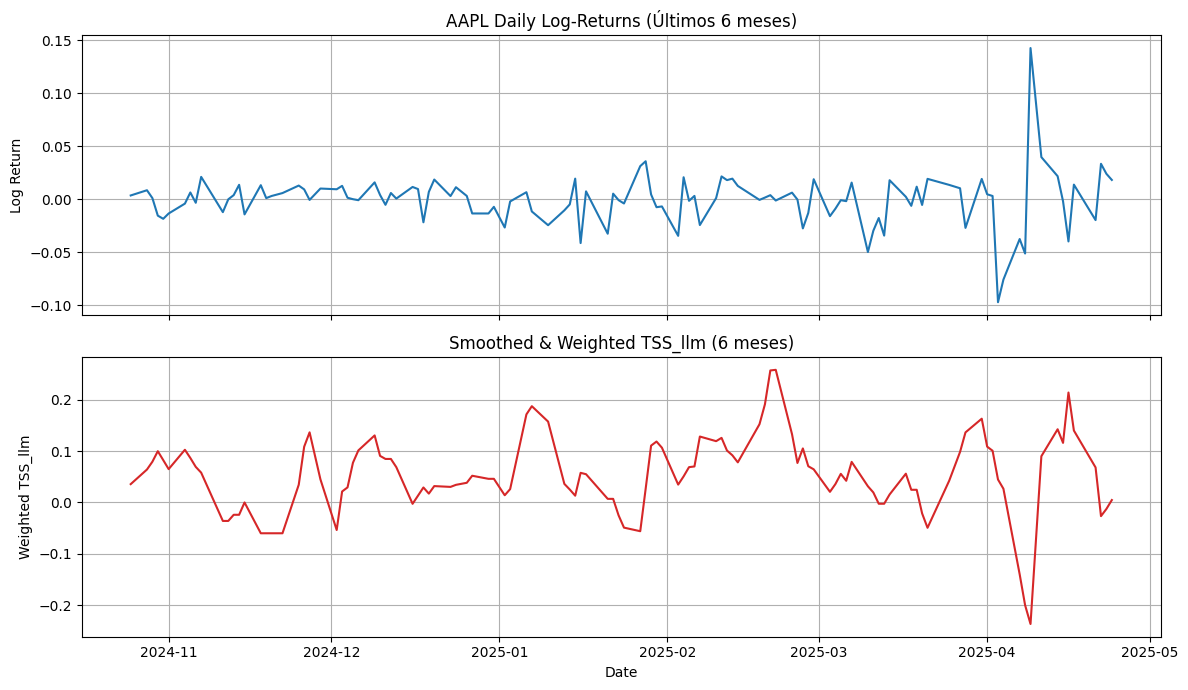

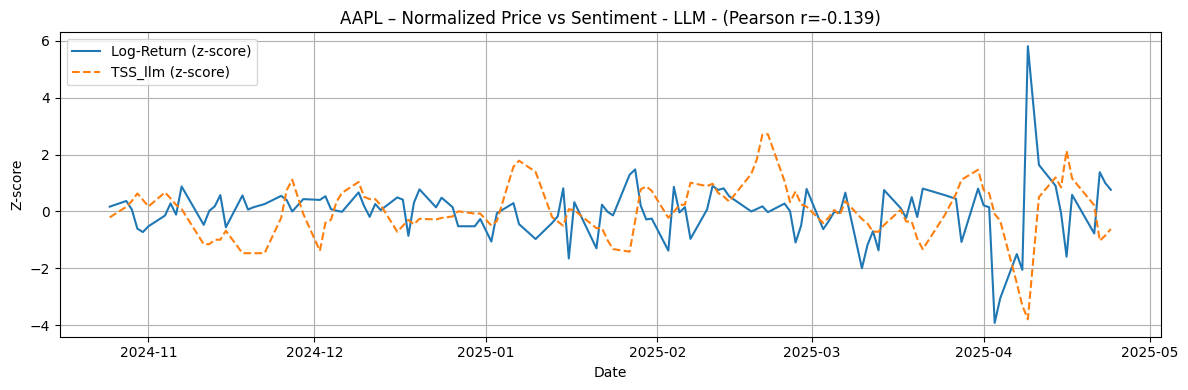

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import load_prices

# Parámetros
months_back = 6
detrend_method = 'log_return'
sentiment_agg = 'daily'
sentiment_lower = None
sentiment_upper = None
min_relevance_score = None

# 1) Carga de precios y log‐returns
df_price = load_prices(ticker, frequency='daily', folder='stocks').copy()
df_price.index.name = 'day_date'
df_price = df_price.sort_index()
# Recorte a últimos 9 meses
last = df_price.index.max()
first = last - pd.DateOffset(months=months_back)
df_price = df_price.loc[first:last]

df_price['log_return'] = np.log(
    df_price['adjusted_close'] / df_price['adjusted_close'].shift(1)
)
price_ts = df_price['log_return'].dropna()

# 2) Cálculo de indicador técnico (p. ej. ponderando TSS_llm)
#    Ajusta aquí si tu indicador cambia; este sigue tu paso original
df_combined['day_date'] = pd.to_datetime(df_combined['day_date'])
df_combined['TSS_llm_weighted'] = (
    df_combined['TSS_llm'] * df_combined['TRS_llm_t']
)
tss_daily = (
    df_combined
      .groupby('day_date')['TSS_llm_weighted']
      .mean()
      .rolling(window=5, center=True, min_periods=1)
      .mean()
      .reset_index()
      .rename(columns={'TSS_llm_weighted':'smoothed_weighted_TSS_llm'})
)
# Asegúrate de filtrar tss_daily al mismo rango de fechas:
tss_daily = tss_daily[
    (tss_daily['day_date'] >= first) &
    (tss_daily['day_date'] <= last)
].set_index('day_date')

# 3) Merge precio + técnico
merged = price_ts.to_frame().join(
    tss_daily, how='inner'
).rename(columns={'log_return':'log_return',
                  'smoothed_weighted_TSS_llm':'sentiment_ts'})

# 4) Gráficos separados
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

ax1.plot(merged.index, merged['log_return'], label='Log‐Return')
ax1.set_ylabel('Log Return')
ax1.set_title(f'{ticker} Daily Log‐Returns (Últimos {months_back} meses)')
ax1.grid(True)

ax2.plot(merged.index, merged['sentiment_ts'], color='C3', label='TSS_llm')
ax2.set_ylabel('Weighted TSS_llm')
ax2.set_title(f'Smoothed & Weighted TSS_llm ({months_back} meses)')
ax2.grid(True)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

# 5) Overlay normalizado + Pearson r
p_z = (merged['log_return'] - merged['log_return'].mean()) / merged['log_return'].std()
s_z = (merged['sentiment_ts'] - merged['sentiment_ts'].mean()) / merged['sentiment_ts'].std()
corr = p_z.corr(s_z)

plt.figure(figsize=(12,4))
plt.plot(merged.index, p_z, label='Log‐Return (z-score)')
plt.plot(merged.index, s_z, '--', label='TSS_llm (z-score)')
plt.title(f'{ticker} – Normalized Price vs Sentiment - LLM - (Pearson r={corr:.3f})')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ***LLM Tech**nical Indicators* - Last 6 Months 

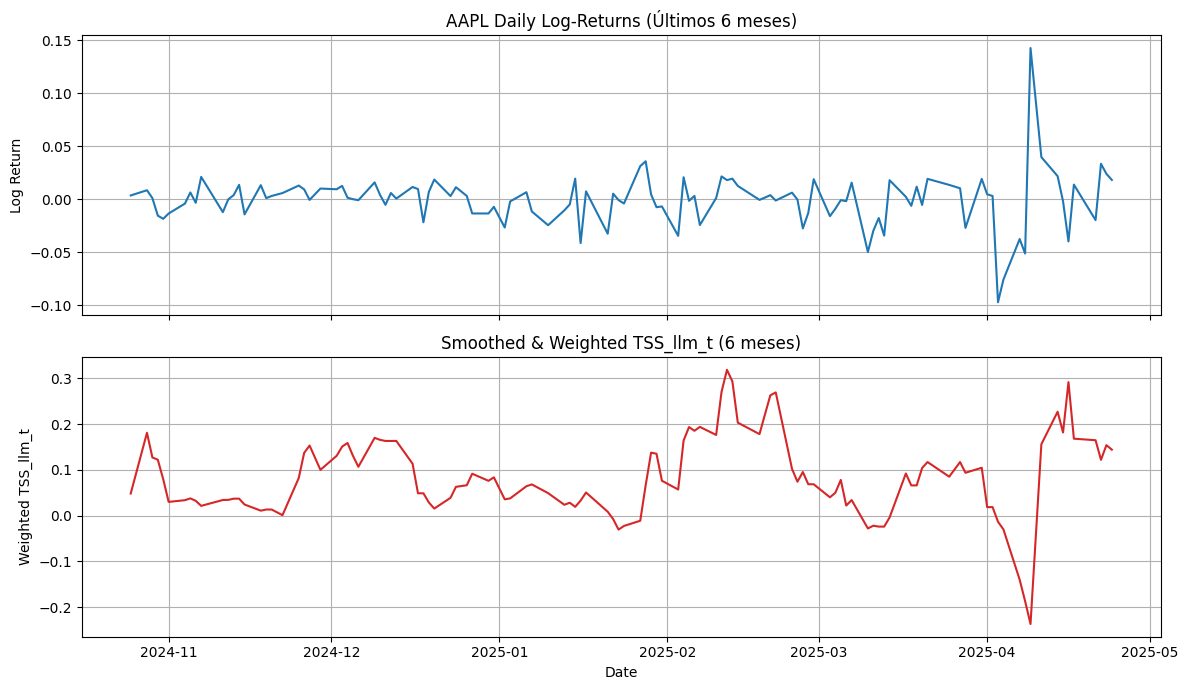

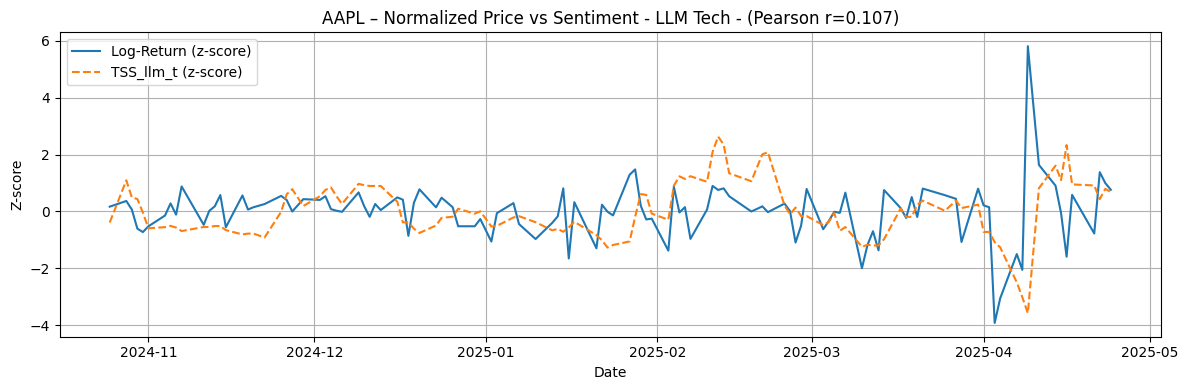

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import load_prices

# Parámetros
months_back = 6
detrend_method = 'log_return'
sentiment_agg = 'daily'
sentiment_lower = None
sentiment_upper = None
min_relevance_score = None

# 1) Carga de precios y log‐returns
df_price = load_prices(ticker, frequency='daily', folder='stocks').copy()
df_price.index.name = 'day_date'
df_price = df_price.sort_index()
# Recorte a últimos 9 meses
last = df_price.index.max()
first = last - pd.DateOffset(months=months_back)
df_price = df_price.loc[first:last]

df_price['log_return'] = np.log(
    df_price['adjusted_close'] / df_price['adjusted_close'].shift(1)
)
price_ts = df_price['log_return'].dropna()

# 2) Cálculo de indicador técnico (p. ej. ponderando TSS_llm_t)
#    Ajusta aquí si tu indicador cambia; este sigue tu paso original
df_combined['day_date'] = pd.to_datetime(df_combined['day_date'])
df_combined['TSS_llm_t_weighted'] = (
    df_combined['TSS_llm_t'] * df_combined['TRS_llm_t']
)
tss_daily = (
    df_combined
      .groupby('day_date')['TSS_llm_t_weighted']
      .mean()
      .rolling(window=5, center=True, min_periods=1)
      .mean()
      .reset_index()
      .rename(columns={'TSS_llm_t_weighted':'smoothed_weighted_TSS_llm_t'})
)
# Asegúrate de filtrar tss_daily al mismo rango de fechas:
tss_daily = tss_daily[
    (tss_daily['day_date'] >= first) &
    (tss_daily['day_date'] <= last)
].set_index('day_date')

# 3) Merge precio + técnico
merged = price_ts.to_frame().join(
    tss_daily, how='inner'
).rename(columns={'log_return':'log_return',
                  'smoothed_weighted_TSS_llm_t':'sentiment_ts'})

# 4) Gráficos separados
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

ax1.plot(merged.index, merged['log_return'], label='Log‐Return')
ax1.set_ylabel('Log Return')
ax1.set_title(f'{ticker} Daily Log‐Returns (Últimos {months_back} meses)')
ax1.grid(True)

ax2.plot(merged.index, merged['sentiment_ts'], color='C3', label='TSS_llm_t')
ax2.set_ylabel('Weighted TSS_llm_t')
ax2.set_title(f'Smoothed & Weighted TSS_llm_t ({months_back} meses)')
ax2.grid(True)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

# 5) Overlay normalizado + Pearson r
p_z = (merged['log_return'] - merged['log_return'].mean()) / merged['log_return'].std()
s_z = (merged['sentiment_ts'] - merged['sentiment_ts'].mean()) / merged['sentiment_ts'].std()
corr = p_z.corr(s_z)

plt.figure(figsize=(12,4))
plt.plot(merged.index, p_z, label='Log‐Return (z-score)')
plt.plot(merged.index, s_z, '--', label='TSS_llm_t (z-score)')
plt.title(f'{ticker} – Normalized Price vs Sentiment - LLM Tech - (Pearson r={corr:.3f})')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ***LLM Tech**nical & **Fund**amental Indicators* - Last 6 Months 

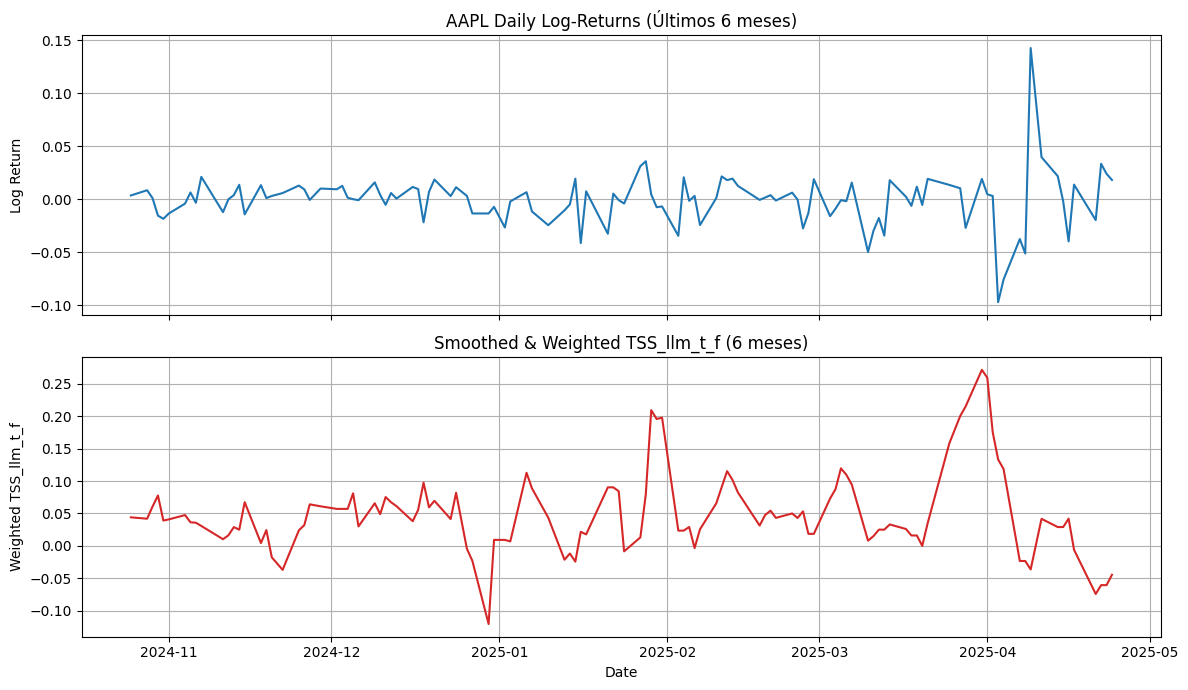

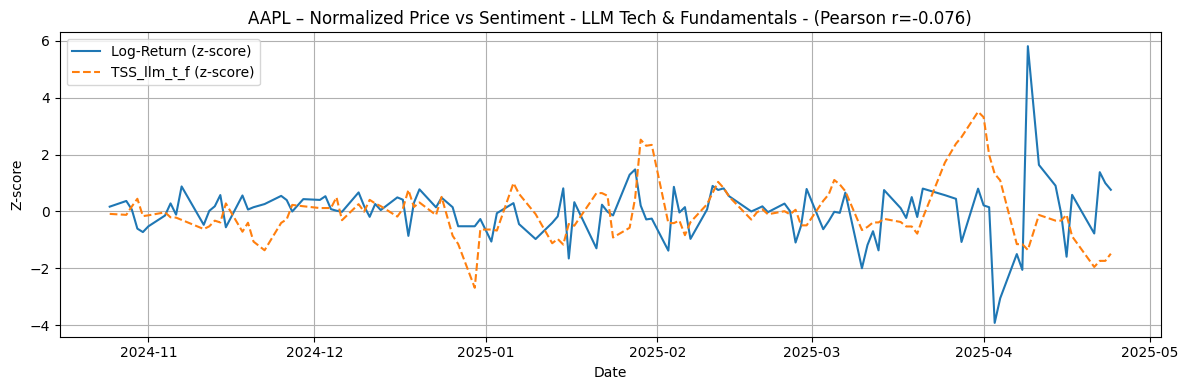

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import load_prices

# Parámetros
months_back = 6
detrend_method = 'log_return'
sentiment_agg = 'daily'
sentiment_lower = None
sentiment_upper = None
min_relevance_score = None

# 1) Carga de precios y log‐returns
df_price = load_prices(ticker, frequency='daily', folder='stocks').copy()
df_price.index.name = 'day_date'
df_price = df_price.sort_index()
# Recorte a últimos 9 meses
last = df_price.index.max()
first = last - pd.DateOffset(months=months_back)
df_price = df_price.loc[first:last]

df_price['log_return'] = np.log(
    df_price['adjusted_close'] / df_price['adjusted_close'].shift(1)
)
price_ts = df_price['log_return'].dropna()

# 2) Cálculo de indicador técnico (p. ej. ponderando TSS_llm_t_f)
#    Ajusta aquí si tu indicador cambia; este sigue tu paso original
df_combined['day_date'] = pd.to_datetime(df_combined['day_date'])
df_combined['TSS_llm_t_f_weighted'] = (
    df_combined['TSS_llm_t_f'] * df_combined['TRS_llm_t_f']
)
tss_daily = (
    df_combined
      .groupby('day_date')['TSS_llm_t_f_weighted']
      .mean()
      .rolling(window=5, center=True, min_periods=1)
      .mean()
      .reset_index()
      .rename(columns={'TSS_llm_t_f_weighted':'smoothed_weighted_TSS_llm_t_f'})
)
# Asegúrate de filtrar tss_daily al mismo rango de fechas:
tss_daily = tss_daily[
    (tss_daily['day_date'] >= first) &
    (tss_daily['day_date'] <= last)
].set_index('day_date')

# 3) Merge precio + técnico
merged = price_ts.to_frame().join(
    tss_daily, how='inner'
).rename(columns={'log_return':'log_return',
                  'smoothed_weighted_TSS_llm_t_f':'sentiment_ts'})

# 4) Gráficos separados
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,7), sharex=True)

ax1.plot(merged.index, merged['log_return'], label='Log‐Return')
ax1.set_ylabel('Log Return')
ax1.set_title(f'{ticker} Daily Log‐Returns (Últimos {months_back} meses)')
ax1.grid(True)

ax2.plot(merged.index, merged['sentiment_ts'], color='C3', label='TSS_llm_t_f')
ax2.set_ylabel('Weighted TSS_llm_t_f')
ax2.set_title(f'Smoothed & Weighted TSS_llm_t_f ({months_back} meses)')
ax2.grid(True)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

# 5) Overlay normalizado + Pearson r
p_z = (merged['log_return'] - merged['log_return'].mean()) / merged['log_return'].std()
s_z = (merged['sentiment_ts'] - merged['sentiment_ts'].mean()) / merged['sentiment_ts'].std()
corr = p_z.corr(s_z)

plt.figure(figsize=(12,4))
plt.plot(merged.index, p_z, label='Log‐Return (z-score)')
plt.plot(merged.index, s_z, '--', label='TSS_llm_t_f (z-score)')
plt.title(f'{ticker} – Normalized Price vs Sentiment - LLM Tech & Fundamentals - (Pearson r={corr:.3f})')
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# VAR

VAR Daily — TSS, TRS y TSS_weighted


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Daily VAR — lag=3, AIC=-60.77, BIC=-59.73


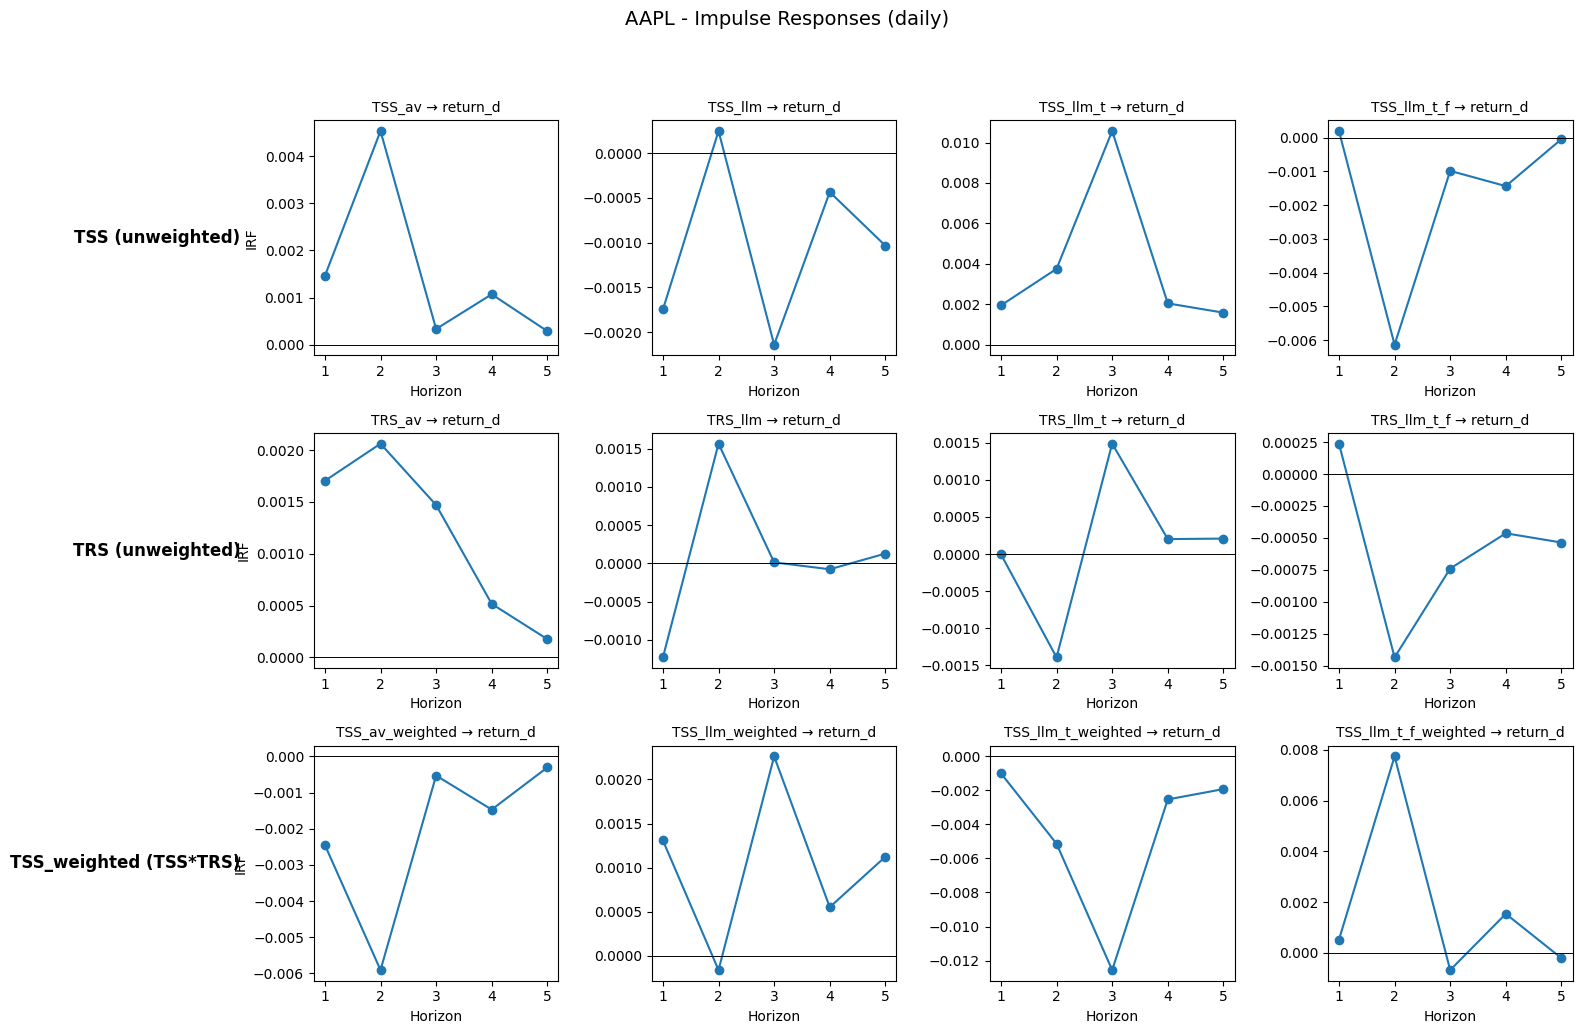

Forecast (next steps):


,TSS_av,TSS_llm,TSS_llm_t,TSS_llm_t_f,TRS_av,TRS_llm,TRS_llm_t,TRS_llm_t_f,TSS_av_weighted,TSS_llm_weighted,TSS_llm_t_weighted,TSS_llm_t_f_weighted,return_d
h+1,0.290149,0.029917,0.167452,0.033070,0.700187,0.648042,0.660007,0.485628,0.200000,0.021075,0.137482,0.026564,0.000179
h+2,0.319618,0.113450,0.176051,0.125292,0.718398,0.670391,0.661059,0.553954,0.229636,0.096714,0.138826,0.099437,0.000405
h+3,0.283631,0.079922,0.152181,0.078629,0.700267,0.646114,0.646170,0.515564,0.194909,0.067523,0.121420,0.058687,0.000897
h+4,0.293941,0.123634,0.136682,0.113479,0.712595,0.637359,0.616305,0.543591,0.207324,0.100403,0.106592,0.084695,0.000404
h+5,0.293340,0.134338,0.132945,0.126678,0.714961,0.636110,0.608760,0.557762,0.207422,0.109823,0.103181,0.094636,0.000374



VAR Weekly — TSS, TRS y TSS_weighted


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Weekly VAR — lag=3, AIC=-60.07, BIC=-59.03


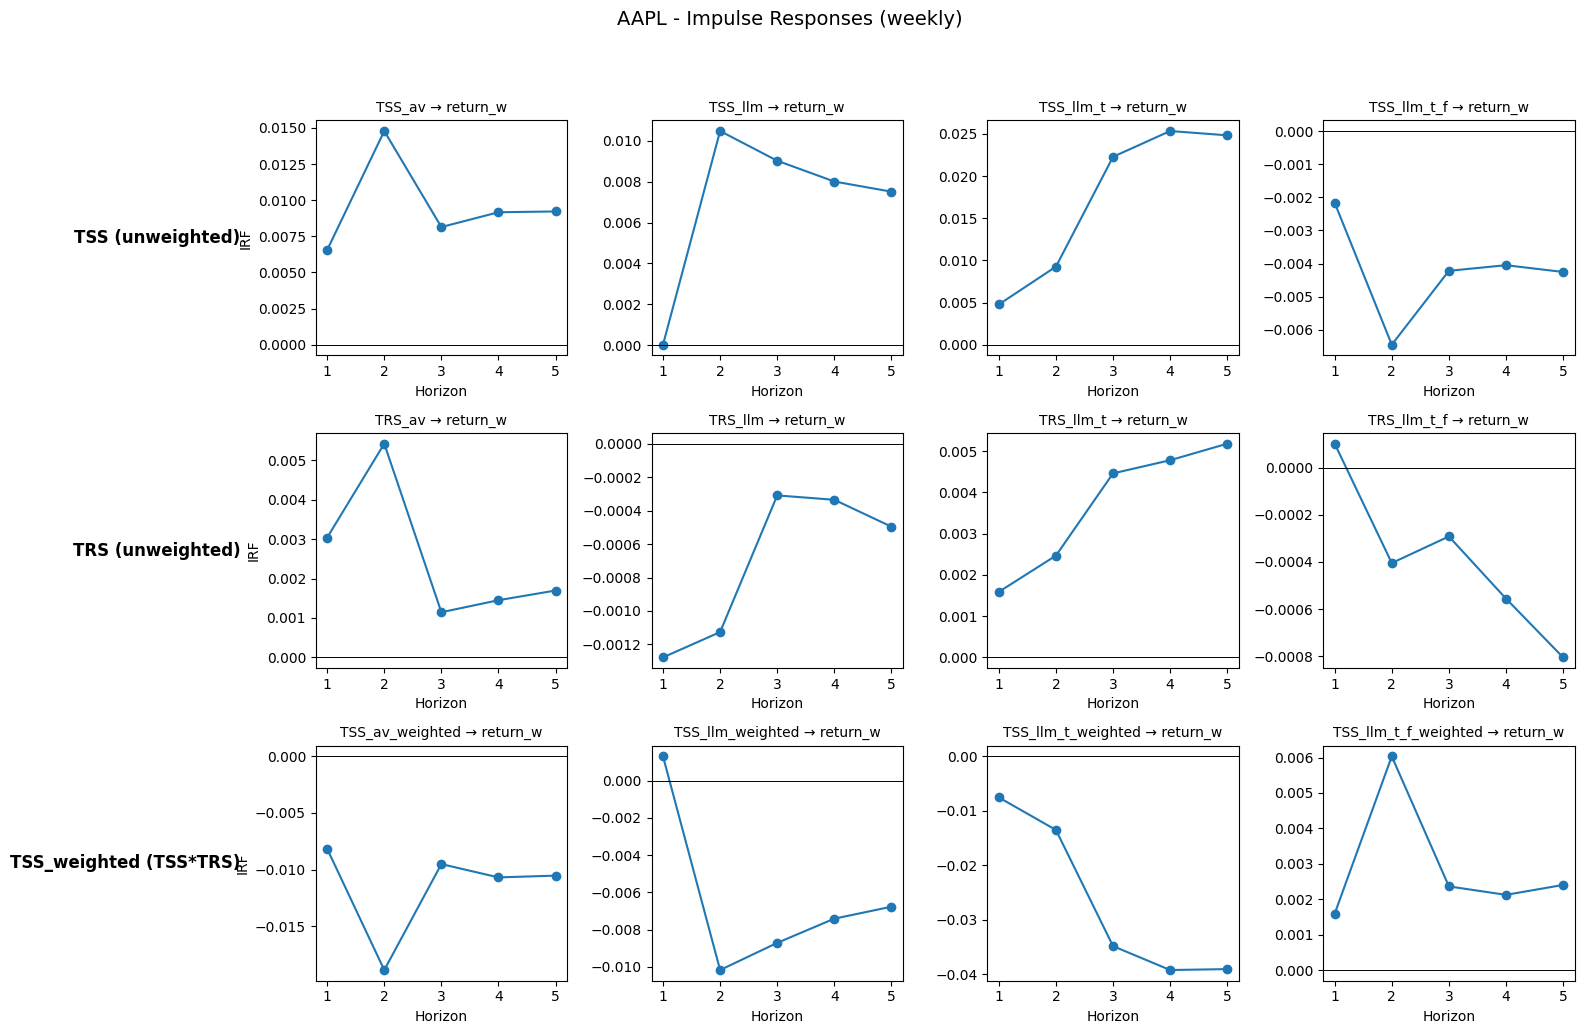

Forecast (next steps):


,TSS_av,TSS_llm,TSS_llm_t,TSS_llm_t_f,TRS_av,TRS_llm,TRS_llm_t,TRS_llm_t_f,TSS_av_weighted,TSS_llm_weighted,TSS_llm_t_weighted,TSS_llm_t_f_weighted,return_w
h+1,0.312510,0.058530,0.202145,0.072847,0.702398,0.644498,0.668209,0.490158,0.216166,0.044253,0.162578,0.056712,0.052803
h+2,0.342834,0.145703,0.213292,0.168037,0.722437,0.669015,0.673629,0.560708,0.246990,0.123583,0.166374,0.131910,0.049923
h+3,0.314035,0.121722,0.198587,0.132338,0.701297,0.642189,0.659072,0.521414,0.216005,0.102185,0.155453,0.100351,0.047416
h+4,0.325154,0.164812,0.181511,0.166485,0.714053,0.634683,0.628996,0.549623,0.229165,0.134655,0.139462,0.125502,0.044846
h+5,0.324639,0.174601,0.176349,0.177787,0.715520,0.633734,0.621039,0.563068,0.229036,0.143275,0.135039,0.134187,0.042539


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from utils import load_prices

# ─── 1) CARGA Y PREPARACIÓN DE RETORNOS ────────────────────────────────────────

df = df_combined.copy()
df['day_date'] = pd.to_datetime(df['day_date'])

# 1.1) precios diarios → return_d
prices_d = (
    load_prices(ticker, frequency='daily', folder='stocks')
    .reset_index().rename(columns={'date':'day_date'})
)
prices_d['day_date'] = pd.to_datetime(prices_d['day_date'])
df = df.merge(prices_d[['day_date','adjusted_close']], on='day_date', how='inner')
df = df.sort_values('day_date')
df['return_d'] = df['adjusted_close'].pct_change()
df = df.dropna(subset=['return_d'])

# 1.2) retorno semanal → return_w
df['week'] = df['day_date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_close = df.groupby('week')['adjusted_close'].last().rename('adj_w')
weekly_ret   = weekly_close.pct_change().rename('return_w')
weekly = pd.DataFrame({'adj_w':weekly_close, 'return_w':weekly_ret}) \
           .dropna().reset_index()
df = df.merge(weekly, on='week', how='inner').dropna(subset=['return_w'])


# ─── 2) CALCULAR TSS_*_WEIGHTED = TSS_* × TRS_* ───────────────────────────────
suffixes = ['av','llm','llm_t','llm_t_f']

for s in suffixes:
    tss_col = f"TSS_{s}"
    trs_col = f"TRS_{s}"
    wcol    = f"{tss_col}_weighted"
    if tss_col in df.columns and trs_col in df.columns:
        df[wcol] = df[tss_col] * df[trs_col]
    else:
        print(f"⚠️ No se crea {wcol}: falta {tss_col} o {trs_col}")


# ─── 3) FUNCIÓN PARA ESTIMAR VAR Y PLOTEAR 3×4 GRID ────────────────────────────

def run_var_grid_tss_trs(
    df: pd.DataFrame,
    frequency: str = 'daily',
    suffixes: list[str] = ['av','llm','llm_t','llm_t_f'],
    maxlags: int = 5,
    forecast_steps: int = 5
):
    # 3.1) elegir tiempo y retorno
    if frequency=='daily':
        tcol, ret = 'day_date','return_d'
    else:
        tcol, ret = 'week','return_w'

    # 3.2) armar listas de variables
    tss_cols   = [f"TSS_{s}"            for s in suffixes if f"TSS_{s}" in df.columns]
    trs_cols   = [f"TRS_{s}"            for s in suffixes if f"TRS_{s}" in df.columns]
    tss_w_cols = [f"TSS_{s}_weighted"   for s in suffixes if f"TSS_{s}_weighted" in df.columns]

    var_order = tss_cols + trs_cols + tss_w_cols + [ret]

    # 3.3) preparar y estacionarizar
    df_var = df[[tcol] + var_order].dropna().set_index(tcol)
    def make_stationary(x):
        y = x.copy()
        for c in x.columns:
            if adfuller(x[c])[1] > 0.05:
                y[c] = x[c].diff()
        return y.dropna()
    df_s = make_stationary(df_var)

    # 3.4) ajustar VAR
    model = VAR(df_s)
    lag   = max(int(model.select_order(maxlags).aic), 1)
    res   = model.fit(lag)
    print(f"{frequency.capitalize()} VAR — lag={lag}, AIC={res.aic:.2f}, BIC={res.bic:.2f}")

    # 3.5) calcular IRFs
    irf_mat = res.irf(forecast_steps).irfs
    h       = forecast_steps
    x       = np.arange(1, h+1)
    ret_ix  = var_order.index(ret)

    # 3.6) plot 3 filas × 4 columnas
    n = len(suffixes)
    fig, axes = plt.subplots(3, n, figsize=(4*n, 3.5*3), squeeze=False)
    row_lists = [tss_cols, trs_cols, tss_w_cols]
    row_labels = ["TSS (unweighted)", "TRS (unweighted)", "TSS_weighted (TSS*TRS)"]

    for row in range(3):
        vars_list = row_lists[row]
        for col in range(n):
            ax = axes[row, col]
            if col < len(vars_list):
                var = vars_list[col]
                y   = irf_mat[1:, ret_ix, var_order.index(var)]
                ax.plot(x, y, marker='o')
            else:
                ax.set_axis_off()
            ax.axhline(0, color='k', lw=0.7)
            title = vars_list[col] + " → " + ret if col < len(vars_list) else ""
            ax.set_title(title, fontsize=10)
            ax.set_xlabel("Horizon")
            if col==0:
                ax.set_ylabel("IRF")
        # etiqueta lateral
        axes[row,0].text(
            -0.3, 0.5, row_labels[row],
            va='center', ha='right',
            transform=axes[row,0].transAxes,
            fontsize=12, fontweight='bold'
        )

    fig.suptitle(f"{ticker} - Impulse Responses ({frequency})", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.94])
    plt.show()

    # 3.7) forecast numérico opcional
    fc    = res.forecast(df_s.values[-lag:], steps=h)
    fc_df = pd.DataFrame(fc, columns=df_s.columns,
                         index=[f"h+{k}" for k in range(1,h+1)])
    print("Forecast (next steps):")
    display(fc_df)


# ─── 4) INVOCACIONES ──────────────────────────────────────────────────────────

print("VAR Daily — TSS, TRS y TSS_weighted")
run_var_grid_tss_trs(df, frequency='daily', suffixes=suffixes,
                     maxlags=5, forecast_steps=5)

print("\nVAR Weekly — TSS, TRS y TSS_weighted")
run_var_grid_tss_trs(df, frequency='weekly', suffixes=suffixes,
                     maxlags=5, forecast_steps=5)


# **VAR** AAPL - *Filtered*
## Data Preparation

In [20]:
import pandas as pd
from functools import reduce


# 2) Build the base directory where your LLM files live
base_dir = Path(r"C:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\data\llm") / ticker

# 3) Define file names
files = {
    "df_news_llm": f"df___{ticker}___llm.csv",
    "df_news_llm_tech": f"df___{ticker}___llm_tech.csv"
}

# 4) Load into variables
df_news_llm = pd.read_csv(base_dir / files["df_news_llm"])
df_news_llm_tech = pd.read_csv(base_dir / files["df_news_llm_tech"])

df_news_av = df_news_filtered.copy()

df_news_av = df_news_av.rename(columns={
    "ticker_sentiment_score": "TSS_av",
    "ticker_relevance_score": "TRS_av"
})
df_news_av = df_news_av[["idx", "time_published","day_date","week_date","TSS_av", "TRS_av"]]
df_news_av = df_news_av[df_news_av['TRS_av'] >= 0.5]

df_news_llm = df_news_llm.rename(columns={
    "ticker_sentiment_score": "TSS_llm",
    "ticker_relevance_score": "TRS_llm",
    "ticker_price_impact": "TPI_llm"
})
df_news_llm = df_news_llm[["idx", "TSS_llm", "TRS_llm", "TPI_llm"]]
df_news_llm = df_news_llm[df_news_llm['TRS_llm'] >= 0.5]

df_news_llm_tech = df_news_llm_tech.rename(columns={
    "ticker_sentiment_score": "TSS_llm_t",
    "ticker_relevance_score": "TRS_llm_t",
    "ticker_price_impact": "TPI_llm_t"
})
df_news_llm_tech = df_news_llm_tech[["idx", "TSS_llm_t", "TRS_llm_t", "TPI_llm_t"]]
df_news_llm_tech = df_news_llm_tech[df_news_llm_tech['TRS_llm_t'] >= 0.5]

dfs = [
    df_news_av,
    df_news_llm,
    df_news_llm_tech
]

# Usamos reduce + pd.merge para hacer un merge sucesivo por 'idx'
df_combined = reduce(
    lambda left, right: pd.merge(left, right, on='idx', how='inner'),
    dfs
)

df_combined.columns
display(print(df_combined['idx'].count()))

1923


None

In [21]:
import pandas as pd
import numpy as np
import importlib

# importa y recarga tu módulo de utilidades
import utils
importlib.reload(utils)
from utils import load_prices

# --- función de agregados ponderados y filtrados ---
def aggregate_all_sentiments(
    df: pd.DataFrame,
    drop_columns: list = ["valuation_label"]
) -> tuple[pd.DataFrame, pd.DataFrame]:
    # copia y limpio
    df_clean = df.drop(columns=drop_columns, errors='ignore').copy()
    df_clean['day_date']  = pd.to_datetime(df_clean['day_date'])
    df_clean['week_date'] = (
        df_clean['day_date']
        .dt.to_period('W')
        .apply(lambda r: r.start_time.date())
    )
    df_clean['week_date'] = pd.to_datetime(df_clean['week_date'])

    # filtro de relevancia (igual que antes)
    df_filt = df_clean[df_clean['TRS_llm'] > 0.6].copy()

    # ---- aquí añadimos TODOS los weighted de TSS_* usando su TRS correspondiente ----
    bases = ['llm', 'llm_t', 'llm_t_f', 'av']
    for b in bases:
        tss_col = f"TSS_{b}"
        trs_col = f"TRS_{b}"
        wcol    = f"{tss_col}_weighted"
        if tss_col in df_filt.columns and trs_col in df_filt.columns:
            df_filt[wcol] = df_filt[tss_col] * df_filt[trs_col]

    # selecciono todas las métricas resultantes (incluye ahora los nuevos _weighted)
    selected_cols = [
        c for c in df_filt.columns
        if c.startswith(('TSS_','TRS_','TPI_'))
    ]

    # agrego por día y por semana
    daily  = (
        df_filt
        .groupby('day_date')[selected_cols]
        .mean()
        .reset_index()
    )
    weekly = (
        df_filt
        .groupby('week_date')[selected_cols]
        .mean()
        .reset_index()
    )

    return daily, weekly

# --- ejecutamos sobre tu df_combined preexistente ---
daily_agg_comb, weekly_agg_comb = aggregate_all_sentiments(df_combined)

# precios diarios
df_prices_daily = load_prices(ticker, frequency='daily', folder='stocks') \
                    .reset_index() \
                    .rename(columns={'date':'day_date'})
df_prices_daily['day_date'] = pd.to_datetime(df_prices_daily['day_date'])

# precios semanales
df_prices_weekly = load_prices(ticker, frequency='weekly', folder='stocks') \
                    .reset_index() \
                    .rename(columns={'date':'week_date'})
df_prices_weekly['week_date'] = pd.to_datetime(df_prices_weekly['week_date'])

# --- merges por fecha ---
merged_daily  = pd.merge(daily_agg_comb,  df_prices_daily,  on='day_date',  how='inner')

# 1) Crea una columna "periodo_semana" en ambos dfs
weekly_agg_comb['periodo_semana']   = weekly_agg_comb['week_date'].dt.to_period('W')
df_prices_weekly['periodo_semana'] = df_prices_weekly['week_date'].dt.to_period('W')

# 2) Merge sobre el periodo
merged_weekly = pd.merge(
    weekly_agg_comb,
    df_prices_weekly,
    on='periodo_semana',
    how='inner'
)

# 3) (opcional) Si quieres volver a una fecha concreta,
#    puedes elegir el inicio ó el fin del periodo:
merged_weekly['week_start'] = merged_weekly['periodo_semana'].dt.start_time
merged_weekly['week_end']   = merged_weekly['periodo_semana'].dt.end_time

# --- creamos lags de retornos ---
for lag in (2, 3):
    merged_daily[f'return_d+{lag}']     = merged_daily['adjusted_close'].shift(-lag)/merged_daily['adjusted_close'] - 1
    merged_daily[f'log_return_d+{lag}'] = np.log(merged_daily['adjusted_close'].shift(-lag)) - np.log(merged_daily['adjusted_close'])

for lag in (2,):
    merged_weekly[f'return_w+{lag}']     = merged_weekly['adjusted_close'].shift(-lag)/merged_weekly['adjusted_close'] - 1
    merged_weekly[f'log_return_w+{lag}'] = np.log(merged_weekly['adjusted_close'].shift(-lag)) - np.log(merged_weekly['adjusted_close'])

# --- preview ---
print("✅ merged_daily:")
print(merged_daily.head(3))
print("\n✅ merged_weekly:")
print(merged_weekly.head(3))


✅ merged_daily:
    day_date    TSS_av    TRS_av  TSS_llm  TRS_llm  TPI_llm  TSS_llm_t  \
0 2022-03-07 -0.219456  0.526629   -0.225     0.75     -0.2     -0.075   
1 2022-03-08 -0.281480  0.629492   -0.800     0.85     -0.7      0.100   
2 2022-03-09  0.608306  0.515127    0.750     0.90      0.6      0.500   

   TRS_llm_t  TPI_llm_t  TSS_llm_weighted  ...  3. low  4. close  \
0       0.70       -0.2           -0.1425  ...  159.04    159.30   
1       0.90       -0.3           -0.6800  ...  155.80    157.44   
2       0.95        0.7            0.6750  ...  159.41    162.95   

   adjusted_close  6. volume  7. dividend amount  8. split coefficient  \
0      156.764994   96418845                 0.0                   1.0   
1      154.934593  131148280                 0.0                   1.0   
2      160.356910   91454905                 0.0                   1.0   

   return_d+2  log_return_d+2  return_d+3  log_return_d+3  
0    0.022913        0.022654   -0.054488       -0.056029

In [22]:
# --- 1) Rename merged_daily price columns ---
merged_daily = merged_daily.rename(columns={
    "1. open":           "open",
    "2. high":           "high",
    "3. low":            "low",
    "4. close":          "close",
    "5. adjusted_close": "adjusted_close",  # if already that name you can drop
    "6. volume":         "volume",
    "7. dividend amount":"dividend"
})

# Ensure the weekly‐return column is also simply named
merged_daily = merged_daily.rename(columns={
    "return_d":    "return_d",
    "return_d+2":  "return_d+2",
    "return_d+3":  "return_d+3",
    "log_return_d+2": "log_return_d+2",
    "log_return_d+3": "log_return_d+3"
})

# If your merged_daily still has both day_date and some other date column, 
# make sure 'day_date' is the index or the canonical date field:
merged_daily['day_date'] = pd.to_datetime(merged_daily['day_date'])
merged_daily = merged_daily.set_index('day_date', drop=False)


# --- 2) Rename merged_weekly price columns & tidy up week_date ---
# First drop the duplicate week_date_y if it exists, then rename week_date_x → week_date
if 'week_date_y' in merged_weekly.columns:
    merged_weekly = merged_weekly.drop(columns=['week_date_y'])

merged_weekly = merged_weekly.rename(columns={
    'week_date_x':      'week_date',
    "1. open":          "open",
    "2. high":          "high",
    "3. low":           "low",
    "4. close":         "close",
    "5. adjusted_close":"adjusted_close",
    "6. volume":        "volume",
    "7. dividend amount":"dividend",
    # your returns lags:
    "return_w":         "return_w",
    "return_w+2":       "return_w+2",
    "log_return_w+2":   "log_return_w+2"
})

# convert week_date to datetime and set index if you like
merged_weekly['week_date'] = pd.to_datetime(merged_weekly['week_date'])
merged_weekly = merged_weekly.set_index('week_date', drop=False)


# --- 3) Verify ---
print(merged_daily.columns)
print(merged_weekly.columns)


Index(['day_date', 'TSS_av', 'TRS_av', 'TSS_llm', 'TRS_llm', 'TPI_llm',
       'TSS_llm_t', 'TRS_llm_t', 'TPI_llm_t', 'TSS_llm_weighted',
       'TSS_llm_t_weighted', 'TSS_av_weighted', 'open', 'high', 'low', 'close',
       'adjusted_close', 'volume', 'dividend', '8. split coefficient',
       'return_d+2', 'log_return_d+2', 'return_d+3', 'log_return_d+3'],
      dtype='object')
Index(['week_date', 'TSS_av', 'TRS_av', 'TSS_llm', 'TRS_llm', 'TPI_llm',
       'TSS_llm_t', 'TRS_llm_t', 'TPI_llm_t', 'TSS_llm_weighted',
       'TSS_llm_t_weighted', 'TSS_av_weighted', 'periodo_semana', 'open',
       'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend',
       'week_start', 'week_end', 'return_w+2', 'log_return_w+2'],
      dtype='object')


⚠️ No se crea TSS_llm_t_f_weighted: falta TSS_llm_t_f o TRS_llm_t_f
VAR Daily — TSS, TRS y TSS_weighted


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Daily VAR — lag=2, AIC=-51.54, BIC=-50.88


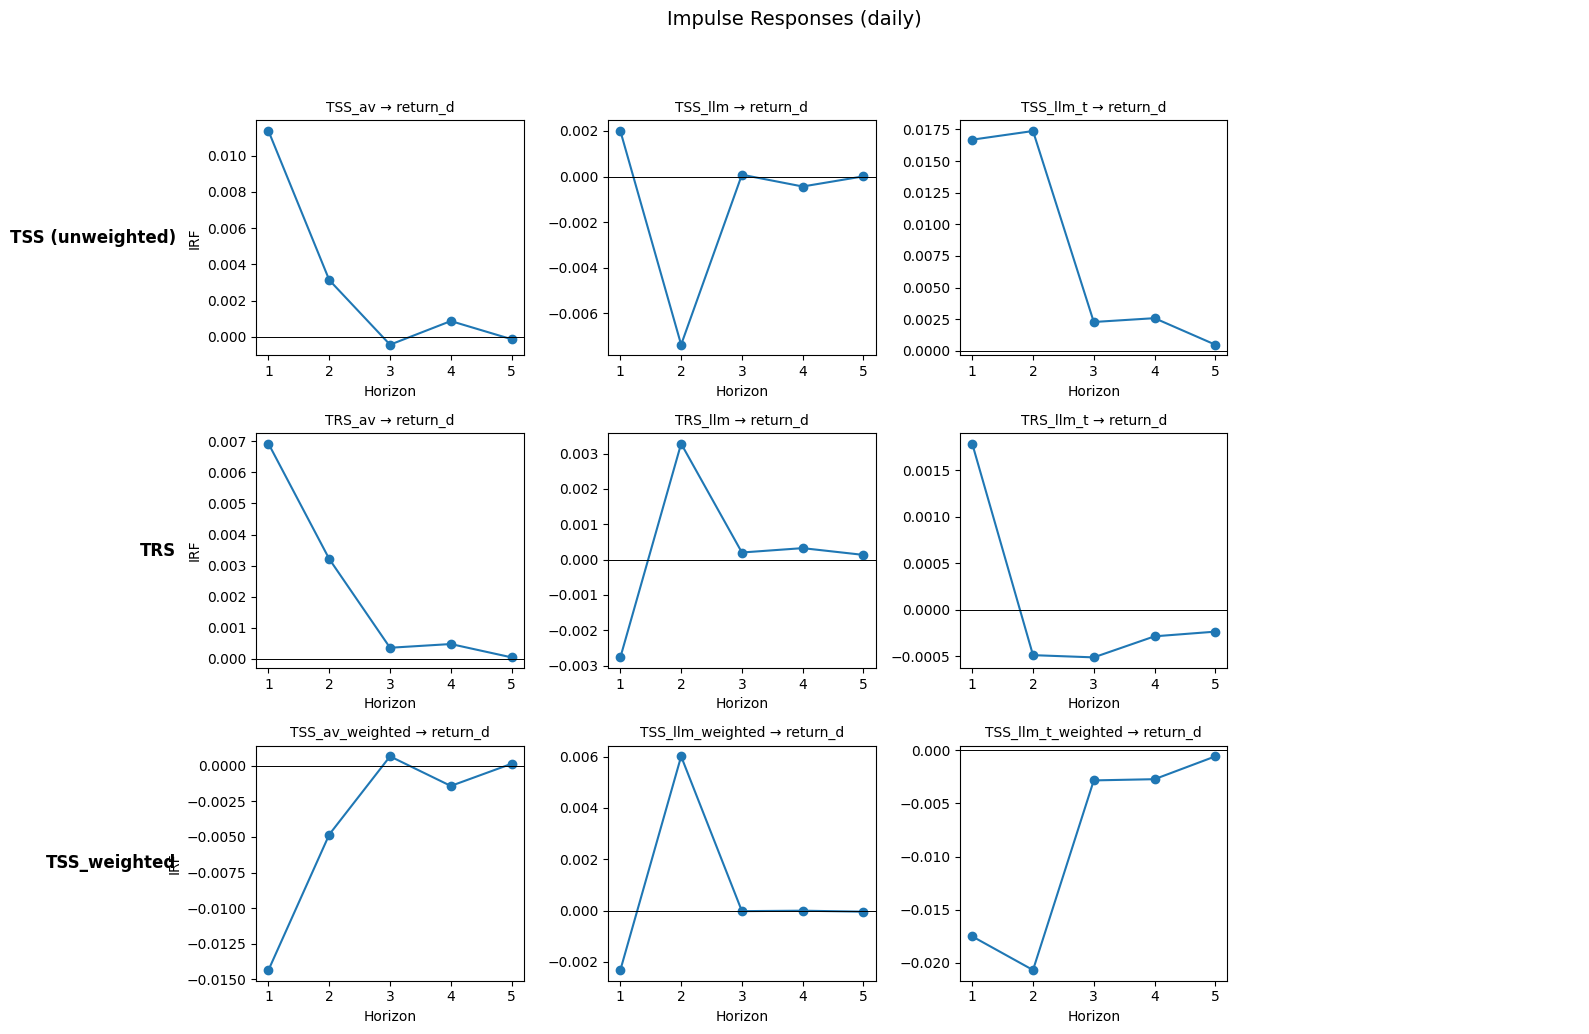

Forecast (next steps):


,TSS_av,TSS_llm,TSS_llm_t,TRS_av,TRS_llm,TRS_llm_t,TSS_av_weighted,TSS_llm_weighted,TSS_llm_t_weighted,return_d
h+1,0.307210,0.035276,0.219497,0.700165,0.762869,0.777132,0.213674,0.024981,0.184031,0.001937
h+2,0.271875,0.082809,0.187610,0.717509,0.765315,0.744975,0.189961,0.065860,0.153367,0.000694
h+3,0.292606,0.152950,0.168182,0.721624,0.761250,0.731144,0.209362,0.123537,0.134517,0.000332
h+4,0.287105,0.168113,0.159581,0.725372,0.761983,0.722522,0.207084,0.136648,0.126072,0.000395
h+5,0.291063,0.187183,0.159866,0.727308,0.762269,0.719521,0.210693,0.152524,0.125635,0.000245



VAR Weekly — TSS, TRS y TSS_weighted


c:\Users\Victor\Downloads\MSc DataScience\MasterThesis - GitHub\venvMasterThesis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Weekly VAR — lag=2, AIC=-50.77, BIC=-50.11


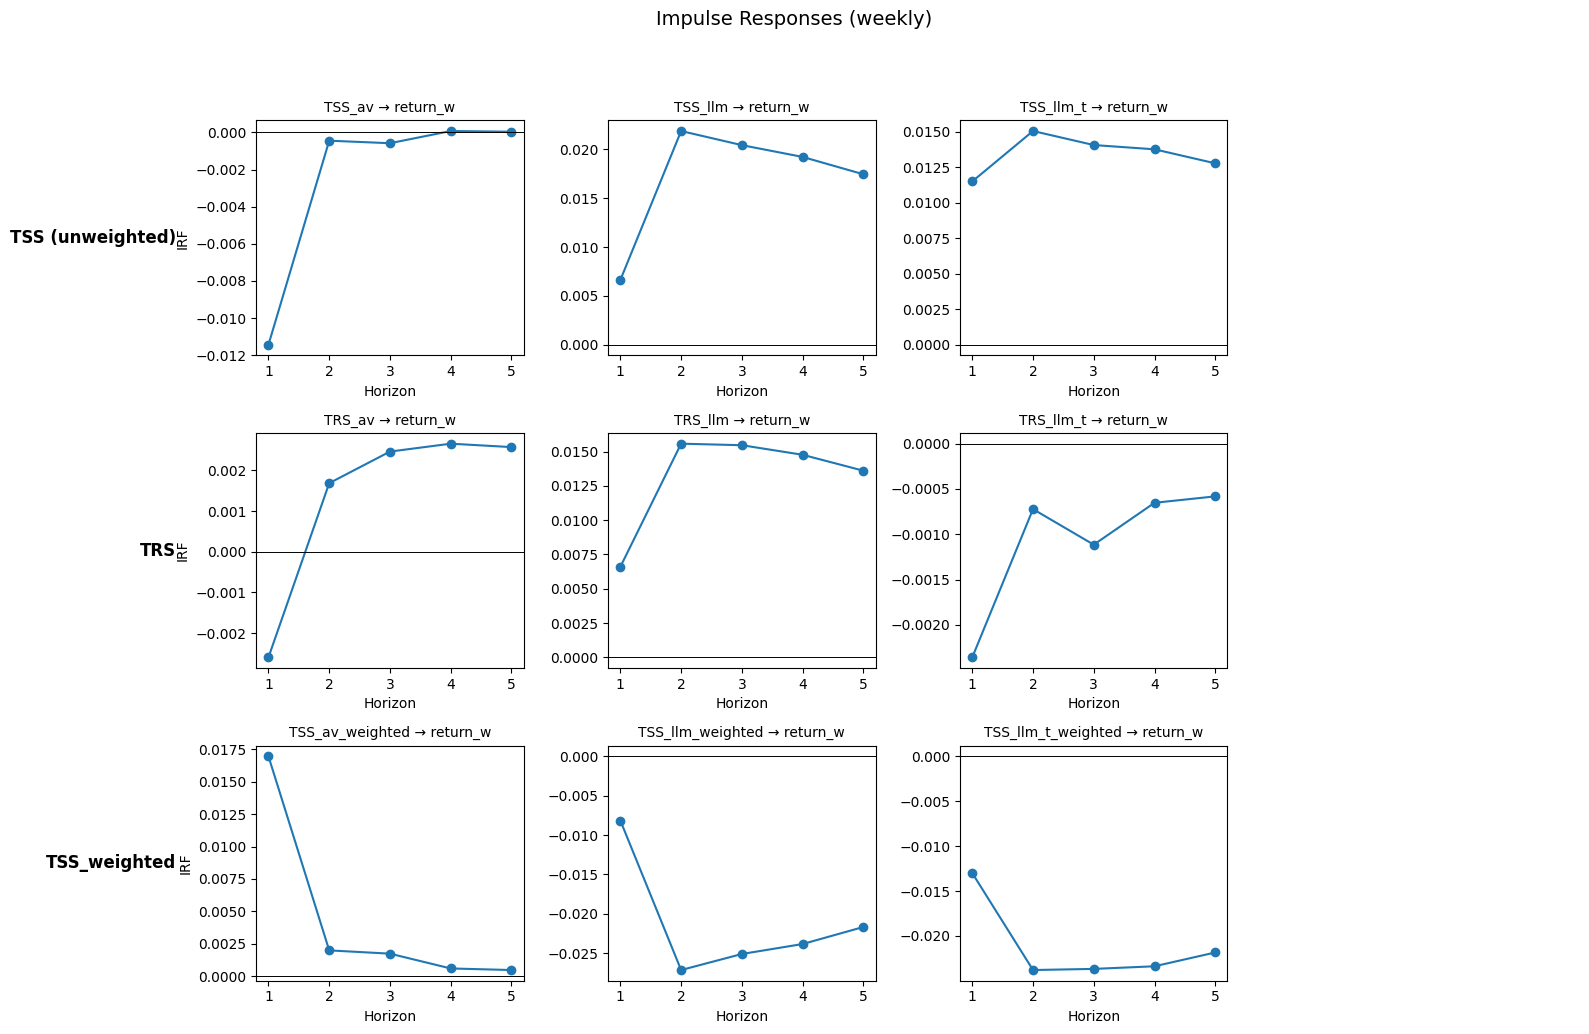

Forecast (next steps):


,TSS_av,TSS_llm,TSS_llm_t,TRS_av,TRS_llm,TRS_llm_t,TSS_av_weighted,TSS_llm_weighted,TSS_llm_t_weighted,return_w
h+1,0.342894,0.088693,0.271686,0.699382,0.758414,0.784975,0.237670,0.068310,0.224803,0.066211
h+2,0.303596,0.133329,0.239371,0.716715,0.759895,0.753709,0.211776,0.106942,0.194072,0.059131
h+3,0.324500,0.206088,0.222606,0.724445,0.756505,0.741218,0.231915,0.166959,0.177232,0.053834
h+4,0.318730,0.220206,0.212769,0.727529,0.757756,0.732647,0.229380,0.179170,0.167870,0.049281
h+5,0.320262,0.236000,0.209635,0.729475,0.758558,0.729145,0.231366,0.192363,0.164749,0.045183


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from utils import load_prices

# ─── 1) CARGA Y PREPARACIÓN DE RETORNOS ────────────────────────────────────────

df = df_combined.copy()
df['day_date'] = pd.to_datetime(df['day_date'])

# 1.1) precios diarios → return_d
prices_d = (
    load_prices('AAPL', frequency='daily', folder='stocks')
    .reset_index().rename(columns={'date':'day_date'})
)
prices_d['day_date'] = pd.to_datetime(prices_d['day_date'])
df = df.merge(prices_d[['day_date','adjusted_close']], on='day_date', how='inner')
df = df.sort_values('day_date')
df['return_d'] = df['adjusted_close'].pct_change()
df = df.dropna(subset=['return_d'])

# 1.2) retorno semanal → return_w
df['week'] = df['day_date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_close = df.groupby('week')['adjusted_close'].last().rename('adj_w')
weekly_ret   = weekly_close.pct_change().rename('return_w')
weekly = pd.DataFrame({'adj_w':weekly_close, 'return_w':weekly_ret}) \
           .dropna().reset_index()
df = df.merge(weekly, on='week', how='inner').dropna(subset=['return_w'])


# ─── 2) CALCULAR TSS_*_WEIGHTED = TSS_* × TRS_* ───────────────────────────────
suffixes = ['av','llm','llm_t','llm_t_f']

for s in suffixes:
    tss_col = f"TSS_{s}"
    trs_col = f"TRS_{s}"
    wcol    = f"{tss_col}_weighted"
    if tss_col in df.columns and trs_col in df.columns:
        df[wcol] = df[tss_col] * df[trs_col]
    else:
        print(f"⚠️ No se crea {wcol}: falta {tss_col} o {trs_col}")


# ─── 3) FUNCIÓN PARA ESTIMAR VAR Y PLOTEAR 3×4 GRID ────────────────────────────

def run_var_grid_tss_trs(
    df: pd.DataFrame,
    frequency: str = 'daily',
    suffixes: list[str] = ['av','llm','llm_t','llm_t_f'],
    maxlags: int = 5,
    forecast_steps: int = 5
):
    # 3.1) elegir tiempo y retorno
    if frequency=='daily':
        tcol, ret = 'day_date','return_d'
    else:
        tcol, ret = 'week','return_w'

    # 3.2) armar listas de variables
    tss_cols   = [f"TSS_{s}"            for s in suffixes if f"TSS_{s}" in df.columns]
    trs_cols   = [f"TRS_{s}"            for s in suffixes if f"TRS_{s}" in df.columns]
    tss_w_cols = [f"TSS_{s}_weighted"   for s in suffixes if f"TSS_{s}_weighted" in df.columns]

    var_order = tss_cols + trs_cols + tss_w_cols + [ret]

    # 3.3) preparar y estacionarizar
    df_var = df[[tcol] + var_order].dropna().set_index(tcol)
    def make_stationary(x):
        y = x.copy()
        for c in x.columns:
            if adfuller(x[c])[1] > 0.05:
                y[c] = x[c].diff()
        return y.dropna()
    df_s = make_stationary(df_var)

    # 3.4) ajustar VAR
    model = VAR(df_s)
    lag   = max(int(model.select_order(maxlags).aic), 1)
    res   = model.fit(lag)
    print(f"{frequency.capitalize()} VAR — lag={lag}, AIC={res.aic:.2f}, BIC={res.bic:.2f}")

    # 3.5) calcular IRFs
    irf_mat = res.irf(forecast_steps).irfs
    h       = forecast_steps
    x       = np.arange(1, h+1)
    ret_ix  = var_order.index(ret)

    # 3.6) plot 3 filas × 4 columnas
    n = len(suffixes)
    fig, axes = plt.subplots(3, n, figsize=(4*n, 3.5*3), squeeze=False)
    row_lists = [tss_cols, trs_cols, tss_w_cols]
    row_labels = ["TSS (unweighted)", "TRS", "TSS_weighted"]

    for row in range(3):
        vars_list = row_lists[row]
        for col in range(n):
            ax = axes[row, col]
            if col < len(vars_list):
                var = vars_list[col]
                y   = irf_mat[1:, ret_ix, var_order.index(var)]
                ax.plot(x, y, marker='o')
            else:
                ax.set_axis_off()
            ax.axhline(0, color='k', lw=0.7)
            title = vars_list[col] + " → " + ret if col < len(vars_list) else ""
            ax.set_title(title, fontsize=10)
            ax.set_xlabel("Horizon")
            if col==0:
                ax.set_ylabel("IRF")
        # etiqueta lateral
        axes[row,0].text(
            -0.3, 0.5, row_labels[row],
            va='center', ha='right',
            transform=axes[row,0].transAxes,
            fontsize=12, fontweight='bold'
        )

    fig.suptitle(f"Impulse Responses ({frequency})", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.94])
    plt.show()

    # 3.7) forecast numérico opcional
    fc    = res.forecast(df_s.values[-lag:], steps=h)
    fc_df = pd.DataFrame(fc, columns=df_s.columns,
                         index=[f"h+{k}" for k in range(1,h+1)])
    print("Forecast (next steps):")
    display(fc_df)


# ─── 4) INVOCACIONES ──────────────────────────────────────────────────────────

print("VAR Daily — TSS, TRS y TSS_weighted")
run_var_grid_tss_trs(df, frequency='daily', suffixes=suffixes,
                     maxlags=5, forecast_steps=5)

print("\nVAR Weekly — TSS, TRS y TSS_weighted")
run_var_grid_tss_trs(df, frequency='weekly', suffixes=suffixes,
                     maxlags=5, forecast_steps=5)
